In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import torch.nn as nn 
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from torchvision import transforms

use_cuda = False
if torch.cuda.is_available():
    torch.cuda.set_device(7)
    use_cuda = True

In [2]:
class ExpLinear(nn.Module):
    def __init__(self, in_size):
        super(ExpLinear, self).__init__()
        self.linear = nn.Sequential(nn.Linear(in_size, 1))
        self.alpha = nn.Sequential(nn.Linear(1, 1, bias=False))
        def prnt(args):
            #print ("grad: ", args)
            #print ("val: ", self.cloned_x)
            pass
        dict(self.alpha.named_parameters())['0.weight'].register_hook(prnt)
        self.cloned_x = None

    def forward(self, x):
        self.cloned_x = self.alpha(torch.exp(self.linear(x))).clone().detach()
        return self.alpha(torch.exp(self.linear(x)))
    
    def get_alpha(self):
        return get_pure(dict(self.alpha.named_parameters())['0.weight'])[0][0]

In [3]:
class Classifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(Classifier_WITH_EXP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_size):
        super(Classifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [5]:
class TwoCircleDataset(Dataset):
    def __init__(self, R1, R2, N, dim, train=False, normalize=True):
        self.R1 = R1
        self.R2 = R2
        self.N = N
        self.dim = dim
        self.train = train
        self.normalize = normalize
        
        self.dots = torch.zeros([N + N // 2, dim])
        
        self.classes = torch.zeros([N + N // 2])
        self.classes.bernoulli_(0.5)
        self.classes = self.classes * 2 - 1
        
        self.normal_generator = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        for idx in range(self.N):
            self.dots[idx] = self.normal_generator.sample_n(self.dim).view(1, -1)
            self.dots[idx] /= torch.sqrt(torch.sum(self.dots[idx] ** 2))
            self.classes[idx] = self.classes[idx]
            if self.classes[idx] == 1:
                self.dots[idx] *= self.R1
            else:
                self.dots[idx] *= self.R2
                
        for idx in range(self.N // 2):
            self.dots[N + idx] = self.normal_generator.sample_n(self.dim).view(1, -1)
            self.dots[N + idx] /= torch.sqrt(torch.sum(self.dots[N + idx] ** 2))
            if self.R1 > self.R2:
                self.classes[N + idx] = 1
                self.dots[idx] *= self.R1 * 2
            else:
                self.classes[N + idx] = -1
                self.dots[idx] *= self.R2 * 2
                
        self.mean = self.dots.mean(dim=0)
        self.std = self.dots.std(dim=0)
        
        if self.normalize:
            self.dots = (self.dots - self.mean.expand_as(self.dots)) / self.std.expand_as(self.dots)
                
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])         

In [6]:
class TwoGaussiansDataset(Dataset):
    def __init__(self, M1, M2, N, dim, train=False):
        self.M1 = M1
        self.M2 = M2
        self.N = N
        self.dim = dim
        self.train = train
        
        self.dots = torch.zeros([N, dim])
        
        self.classes = torch.zeros([N])
        self.classes.bernoulli_(0.5)
        self.classes = self.classes * 2 - 1
        
        self.normal_generator_1 = torch.distributions.normal.Normal(torch.tensor([M1]), torch.tensor([1.0]))
        self.normal_generator_2 = torch.distributions.normal.Normal(torch.tensor([M2]), torch.tensor([1.0]))
        for idx in range(self.N):
            if self.classes[idx] == 1:
                self.dots[idx] = self.normal_generator_1.sample_n(self.dim).view(1, -1)
            else:
                self.dots[idx] = self.normal_generator_2.sample_n(self.dim).view(1, -1)
        
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])

In [7]:
dataset_c_train = TwoCircleDataset(1, 10, 400, 20, train=True)
dataset_c_test = TwoCircleDataset(1, 10, 400, 20, train=False)
dataloader_c_train = DataLoader(dataset_c_train, batch_size=128, shuffle=True)
dataloader_c_test = DataLoader(dataset_c_test, batch_size=128, shuffle=True)

dataset_g_train = TwoGaussiansDataset(0., 0.1, 10000, 100, train=True)
dataset_g_test = TwoGaussiansDataset(0., 0., 10000, 100, train=False)
dataloader_g_train = DataLoader(dataset_g_train, batch_size=128, shuffle=True)
dataloader_g_test = DataLoader(dataset_g_test, batch_size=128, shuffle=True)

In [11]:
def get_pure(args):
    return args.data.cpu().clone().numpy()

In [63]:
def train_WITH_EXP(network, optimizer, reg_lambda, epochs, dataloader_train, dataloader_test, verbose=True):
    def loss_func(predict_y, correct_y, network, reg_lambda):
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        reg_loss = None
        for param in network.explinear.alpha.parameters():
            reg_loss = reg_lambda * param.norm(2)
        return loss + reg_loss, reg_loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    alpha = []    
    reg_losses = []
    try:
        for epoch in range(epochs):
#             if epoch % 10 == 0:
#                 optimizer = torch.optim.Adam(net_WITH_EXP.parameters(), lr=.0005)
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())

                predict_y = network(x)
                loss, _ = loss_func(predict_y, correct_y, network, reg_lambda)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            alpha.append(network.get_alpha())
            
            loss, reg_loss = loss_func(network(dataloader_train.dataset.dots),
                                       dataloader_train.dataset.classes, network,
                                       reg_lambda)
            losses_train.append(get_pure(loss))
            reg_losses.append(get_pure(reg_loss))
            misscl_rate_train.append(
                (np.where(get_pure(network(dataloader_train.dataset.dots)) < 0, -1, 1) != 
                dataloader_train.dataset.classes.numpy()).sum())
            
            loss, _ = loss_func(network(dataloader_test.dataset.dots),
                                dataloader_test.dataset.classes, network,
                                reg_lambda)
            losses_test.append(get_pure(loss))
            misscl_rate_test.append(
                (np.where(get_pure(network(dataloader_test.dataset.dots)) < 0, -1, 1) != 
                dataloader_test.dataset.classes.numpy()).sum())
                
            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
            
            if math.isnan(losses_train[-1]):              
                raise KeyboardInterrupt
    except KeyboardInterrupt:
        pass
    if verbose:
        plt.figure(figsize=(30, 20))

        plt.subplot(2, 3, 1)
        plt.plot(losses_train, label='Loss (Train)')
        plt.plot(losses_test, label='Loss (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)

        plt.subplot(2, 3, 2)
        plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
        plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Number of objects', fontsize=16)
        plt.legend(loc=0, fontsize=16)

        plt.subplot(2, 3, 3)
        plt.plot(alpha, label='Alpha')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Alpha', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.figure(figsize=(30, 10))

        plt.subplot(2, 3, 4)
        plt.plot(reg_losses, label='Reg Loss')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean reg loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
    
    return losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]

In [64]:
def train(network, optimizer, epochs, dataloader_train, dataloader_test, verbose=True):
    def loss_func(predict_y, correct_y):
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        return loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    try:
        for epoch in range(epochs):
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                
                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses_train.append(loss_func(network(dataloader_train.dataset.dots), dataloader_train.dataset.classes))
            misscl_rate_train.append((np.where(get_pure(network(dataloader_train.dataset.dots)) < 0, -1, 1) != dataloader_train.dataset.classes.numpy()).sum())

            losses_test.append(loss_func(network(dataloader_test.dataset.dots), dataloader_test.dataset.classes))
            misscl_rate_test.append((np.where(get_pure(network(dataloader_test.dataset.dots)) < 0, -1, 1) != dataloader_test.dataset.classes.numpy()).sum())

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
            
            if math.isnan(losses_train[-1]):
                raise KeyboardInterrupt
    except KeyboardInterrupt:
        pass
    if verbose:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.plot(losses_train, label='Loss (Train)')
        plt.plot(losses_test, label='Loss (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(1, 2, 2)
        plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
        plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Number of objects', fontsize=16)
        plt.legend(loc=0, fontsize=16)
    
    return losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]    

## Two N-dim concentric spheres

### Without Exp Neuron

In [109]:
net = Classifier(20)
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

Epoch 9999... Empirical Loss/Misclassification Rate (Train): 294.683/100.000	 Empirical Loss/Misclassification Rate (Test): 4086.541/216.000

(tensor(294.6831), 100, tensor(4086.5408), 216)

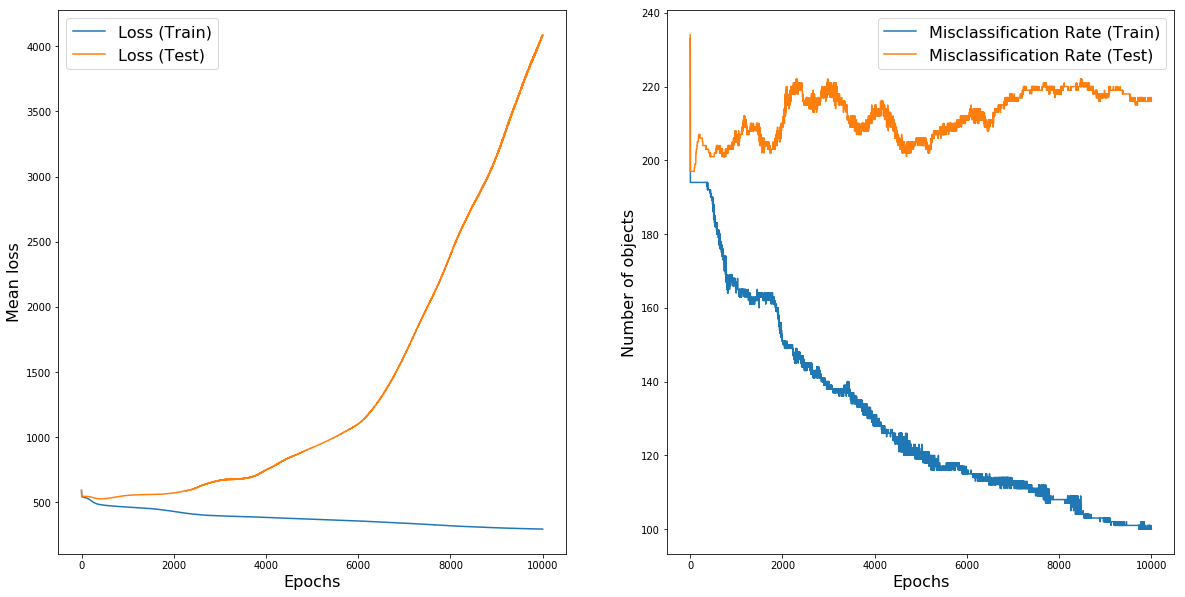

In [110]:
train(net, optimizer, 10000, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

### With Exp Neuron

In [67]:
net_WITH_EXP = Classifier_WITH_EXP(20)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=5)

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.000

(array(nan, dtype=float32), 400, array(nan, dtype=float32), 401)

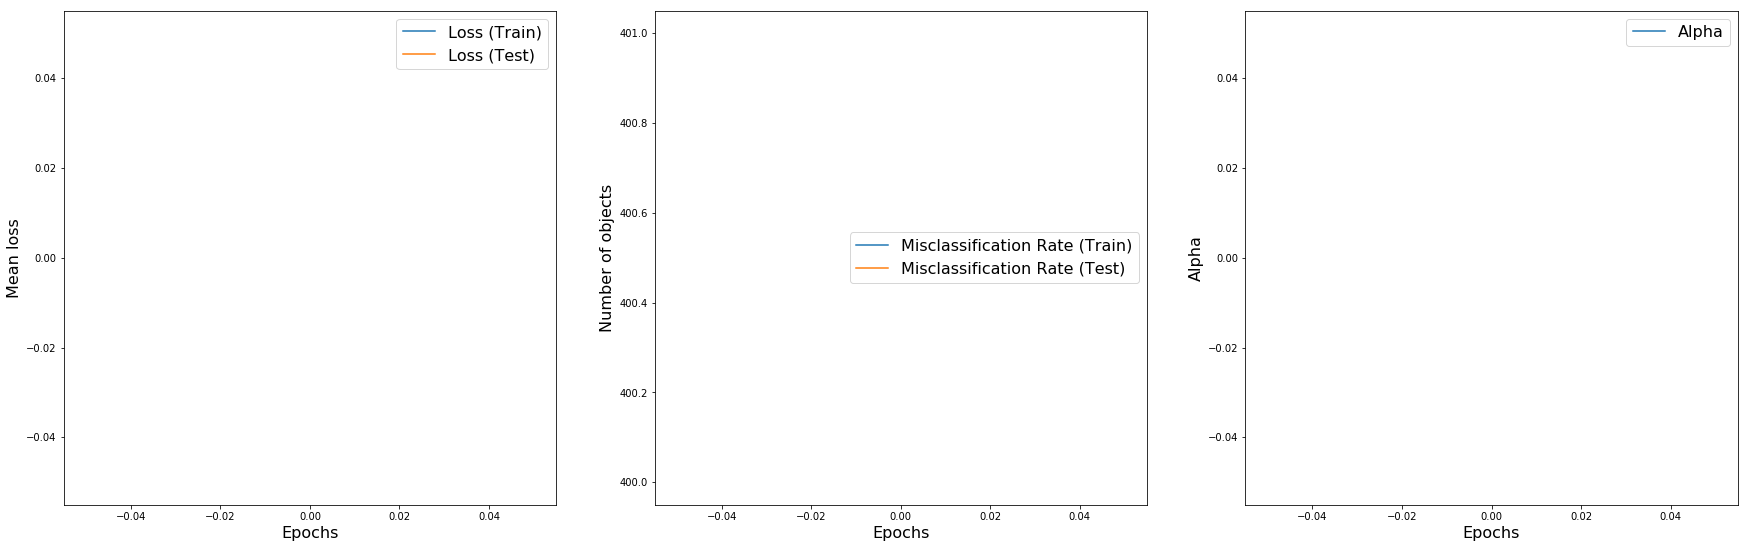

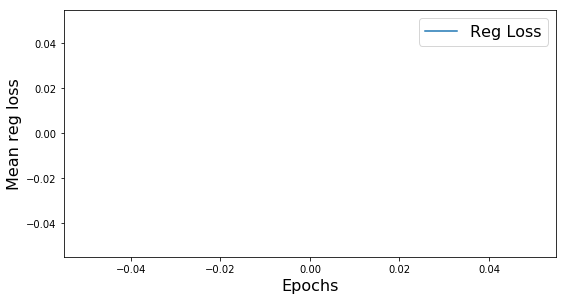

In [68]:
train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=0.2, epochs=10000, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [ ]:
net_WITH_EXP = Classifier_WITH_EXP(20)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=0.0002)

In [ ]:
train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=10., epochs=1000, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [ ]:
net_WITH_EXP = Classifier_WITH_EXP(20)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=0.00005)

In [ ]:
train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=.0005, epochs=1000, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [ ]:
train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=.005, epochs=100, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [99]:
params = np.zeros([100, 100, 3])

In [100]:
# for idx, lr in enumerate(np.linspace(0.0001, 10, 10)):
#     for jdx, lamb in enumerate(np.linspace(0.0001, 10, 10)):
#         print (idx, jdx)
#         net_WITH_EXP = Classifier_WITH_EXP(20)
#         optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=float(lr))
#         res = train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=float(lamb), epochs=500, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test, verbose=False)
#         params[idx][jdx] = [lr, lamb, res[0]]
#         if np.isnan(params[idx][jdx][2]) or np.isinf(params[idx][jdx][2]):
#             params[idx][jdx][2] = -1000

for idx, lr in enumerate(np.logspace(-4, 1, 100)):
    for jdx, lamb in enumerate(np.logspace(-4, 1, 100)):
        print (idx, jdx)
        net_WITH_EXP = Classifier_WITH_EXP(20)
        optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=float(lr))
        res = train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=float(lamb), epochs=100, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test, verbose=False)
        params[idx][jdx] = [lr, lamb, res[0]]
        if np.isnan(params[idx][jdx][2]) or np.isinf(params[idx][jdx][2]):
            params[idx][jdx][2] = -1000

0 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1333.485/200.000	 Empirical Loss/Misclassification Rate (Test): 1340.304/199.0000 1
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1013.167/400.000	 Empirical Loss/Misclassification Rate (Test): 1128.719/401.0000 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 7010.481/400.000	 Empirical Loss/Misclassification Rate (Test): 6610.968/401.0000 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 23957.215/374.000	 Empirical Loss/Misclassification Rate (Test): 3765.036/366.0000 4
Epoch 99... Empirical Loss/Misclassification Rate (Train): 4920.242/400.000	 Empirical Loss/Misclassification Rate (Test): 6641.524/401.0000 5
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1288.608/200.000	 Empirical Loss/Misclassification Rate (Test): 1315.539/199.0000 6
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1344.450/240.000	 Empirical Loss/Misclassification Rate (Test): 1235.516/243.0

Epoch 99... Empirical Loss/Misclassification Rate (Train): 55309.375/377.000	 Empirical Loss/Misclassification Rate (Test): 55098.855/360.0000 58
Epoch 99... Empirical Loss/Misclassification Rate (Train): 577.603/231.000	 Empirical Loss/Misclassification Rate (Test): 591.229/235.0000 59
Epoch 99... Empirical Loss/Misclassification Rate (Train): 567.502/233.000	 Empirical Loss/Misclassification Rate (Test): 562.911/225.0000 60
Epoch 99... Empirical Loss/Misclassification Rate (Train): 552.342/200.000	 Empirical Loss/Misclassification Rate (Test): 560.137/199.0000 61
Epoch 99... Empirical Loss/Misclassification Rate (Train): 582.798/239.000	 Empirical Loss/Misclassification Rate (Test): 575.955/237.0000 62
Epoch 99... Empirical Loss/Misclassification Rate (Train): 536.045/216.000	 Empirical Loss/Misclassification Rate (Test): 553.403/225.0000 63
Epoch 99... Empirical Loss/Misclassification Rate (Train): 829.085/213.000	 Empirical Loss/Misclassification Rate (Test): 841.457/212.0000 64
Ep

Epoch 99... Empirical Loss/Misclassification Rate (Train): 552.386/201.000	 Empirical Loss/Misclassification Rate (Test): 554.461/202.0001 15
Epoch 99... Empirical Loss/Misclassification Rate (Train): 54144.605/382.000	 Empirical Loss/Misclassification Rate (Test): 20234.238/386.0001 16
Epoch 99... Empirical Loss/Misclassification Rate (Train): 603.229/239.000	 Empirical Loss/Misclassification Rate (Test): 615.638/237.0001 17
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1984.187/357.000	 Empirical Loss/Misclassification Rate (Test): 4217.810/374.0001 18
Epoch 99... Empirical Loss/Misclassification Rate (Train): 966.679/200.000	 Empirical Loss/Misclassification Rate (Test): 1041.769/199.0001 19
Epoch 99... Empirical Loss/Misclassification Rate (Train): 778.603/200.000	 Empirical Loss/Misclassification Rate (Test): 792.288/199.0001 20
Epoch 99... Empirical Loss/Misclassification Rate (Train): 578.846/212.000	 Empirical Loss/Misclassification Rate (Test): 567.006/210.0001 21

Epoch 99... Empirical Loss/Misclassification Rate (Train): 580.147/225.000	 Empirical Loss/Misclassification Rate (Test): 612.663/235.0001 72
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1058.864/200.000	 Empirical Loss/Misclassification Rate (Test): 1075.356/199.0001 73
Epoch 99... Empirical Loss/Misclassification Rate (Train): 11095.190/389.000	 Empirical Loss/Misclassification Rate (Test): 24919.088/388.0001 74
Epoch 99... Empirical Loss/Misclassification Rate (Train): 975.089/387.000	 Empirical Loss/Misclassification Rate (Test): 2157.679/383.0001 75
Epoch 99... Empirical Loss/Misclassification Rate (Train): 580.191/200.000	 Empirical Loss/Misclassification Rate (Test): 603.755/199.0001 76
Epoch 99... Empirical Loss/Misclassification Rate (Train): 18139.773/375.000	 Empirical Loss/Misclassification Rate (Test): 3821.190/383.0001 77
Epoch 99... Empirical Loss/Misclassification Rate (Train): 560.852/231.000	 Empirical Loss/Misclassification Rate (Test): 568.165/237.0001

Epoch 99... Empirical Loss/Misclassification Rate (Train): 561.073/208.000	 Empirical Loss/Misclassification Rate (Test): 560.781/206.0002 29
Epoch 99... Empirical Loss/Misclassification Rate (Train): 607.765/220.000	 Empirical Loss/Misclassification Rate (Test): 685.958/221.0002 30
Epoch 99... Empirical Loss/Misclassification Rate (Train): 794.533/209.000	 Empirical Loss/Misclassification Rate (Test): 839.491/209.0002 31
Epoch 99... Empirical Loss/Misclassification Rate (Train): 538.159/200.000	 Empirical Loss/Misclassification Rate (Test): 540.506/200.0002 32
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3239.284/375.000	 Empirical Loss/Misclassification Rate (Test): 2293.634/375.0002 33
Epoch 99... Empirical Loss/Misclassification Rate (Train): 622.579/200.000	 Empirical Loss/Misclassification Rate (Test): 611.531/199.0002 34
Epoch 99... Empirical Loss/Misclassification Rate (Train): 868.912/202.000	 Empirical Loss/Misclassification Rate (Test): 851.905/202.0002 35
Epoc

Epoch 99... Empirical Loss/Misclassification Rate (Train): 537.057/200.000	 Empirical Loss/Misclassification Rate (Test): 538.452/199.0002 86
Epoch 99... Empirical Loss/Misclassification Rate (Train): 19573.568/400.000	 Empirical Loss/Misclassification Rate (Test): 9417.514/401.0002 87
Epoch 99... Empirical Loss/Misclassification Rate (Train): 559.763/230.000	 Empirical Loss/Misclassification Rate (Test): 568.970/234.0002 88
Epoch 99... Empirical Loss/Misclassification Rate (Train): 834.786/209.000	 Empirical Loss/Misclassification Rate (Test): 861.592/210.0002 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 607.156/214.000	 Empirical Loss/Misclassification Rate (Test): 625.598/220.0002 90
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2930.643/400.000	 Empirical Loss/Misclassification Rate (Test): 2333.380/401.0002 91
Epoch 99... Empirical Loss/Misclassification Rate (Train): 678.213/236.000	 Empirical Loss/Misclassification Rate (Test): 1023.071/235.0002 92


Epoch 99... Empirical Loss/Misclassification Rate (Train): 10435.274/362.000	 Empirical Loss/Misclassification Rate (Test): 6179.142/365.0003 43
Epoch 99... Empirical Loss/Misclassification Rate (Train): 555.629/236.000	 Empirical Loss/Misclassification Rate (Test): 557.972/237.0003 44
Epoch 99... Empirical Loss/Misclassification Rate (Train): 924.778/204.000	 Empirical Loss/Misclassification Rate (Test): 1036.139/205.0003 45
Epoch 99... Empirical Loss/Misclassification Rate (Train): 576.455/221.000	 Empirical Loss/Misclassification Rate (Test): 600.976/223.0003 46
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1335.764/200.000	 Empirical Loss/Misclassification Rate (Test): 1462.639/200.0003 47
Epoch 99... Empirical Loss/Misclassification Rate (Train): 841.726/200.000	 Empirical Loss/Misclassification Rate (Test): 913.866/199.0003 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 553.121/204.000	 Empirical Loss/Misclassification Rate (Test): 553.593/202.0003 49


Epoch 99... Empirical Loss/Misclassification Rate (Train): 537.793/200.000	 Empirical Loss/Misclassification Rate (Test): 543.911/199.0004 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 733.743/379.000	 Empirical Loss/Misclassification Rate (Test): 961.610/374.0004 1
Epoch 99... Empirical Loss/Misclassification Rate (Train): 31342.895/357.000	 Empirical Loss/Misclassification Rate (Test): 6572.182/371.0004 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1051.965/230.000	 Empirical Loss/Misclassification Rate (Test): 1234.533/226.0004 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 542.142/215.000	 Empirical Loss/Misclassification Rate (Test): 551.328/223.0004 4
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1109.813/365.000	 Empirical Loss/Misclassification Rate (Test): 5265.401/320.0004 5
Epoch 99... Empirical Loss/Misclassification Rate (Train): 563.657/210.000	 Empirical Loss/Misclassification Rate (Test): 559.978/210.0004 6
Epoch 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 704.029/229.000	 Empirical Loss/Misclassification Rate (Test): 1549.942/237.0004 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 13698.771/359.000	 Empirical Loss/Misclassification Rate (Test): 74137.219/371.0004 58
Epoch 99... Empirical Loss/Misclassification Rate (Train): 833.657/200.000	 Empirical Loss/Misclassification Rate (Test): 861.772/199.0004 59
Epoch 99... Empirical Loss/Misclassification Rate (Train): 811.585/205.000	 Empirical Loss/Misclassification Rate (Test): 823.118/202.0004 60
Epoch 99... Empirical Loss/Misclassification Rate (Train): 10187.482/365.000	 Empirical Loss/Misclassification Rate (Test): 4780.944/365.0004 61
Epoch 99... Empirical Loss/Misclassification Rate (Train): 636.110/230.000	 Empirical Loss/Misclassification Rate (Test): 656.698/219.0004 62
Epoch 99... Empirical Loss/Misclassification Rate (Train): 537.768/224.000	 Empirical Loss/Misclassification Rate (Test): 570.644/233.0004 6

Epoch 99... Empirical Loss/Misclassification Rate (Train): 564.103/233.000	 Empirical Loss/Misclassification Rate (Test): 555.341/232.0005 14
Epoch 99... Empirical Loss/Misclassification Rate (Train): 592.359/200.000	 Empirical Loss/Misclassification Rate (Test): 598.442/199.0005 15
Epoch 99... Empirical Loss/Misclassification Rate (Train): 580.127/220.000	 Empirical Loss/Misclassification Rate (Test): 635.796/225.0005 16
Epoch 99... Empirical Loss/Misclassification Rate (Train): 779.151/200.000	 Empirical Loss/Misclassification Rate (Test): 836.868/199.0005 17
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1888.674/366.000	 Empirical Loss/Misclassification Rate (Test): 7616.735/371.0005 18
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2685.963/376.000	 Empirical Loss/Misclassification Rate (Test): 4235.684/355.0005 19
Epoch 99... Empirical Loss/Misclassification Rate (Train): 27332.863/233.000	 Empirical Loss/Misclassification Rate (Test): 1202.276/228.0005 20

Epoch 99... Empirical Loss/Misclassification Rate (Train): 543.344/226.000	 Empirical Loss/Misclassification Rate (Test): 566.433/239.0005 71
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1018.060/231.000	 Empirical Loss/Misclassification Rate (Test): 2280.613/237.0005 72
Epoch 99... Empirical Loss/Misclassification Rate (Train): 560.186/200.000	 Empirical Loss/Misclassification Rate (Test): 564.909/199.0005 73
Epoch 99... Empirical Loss/Misclassification Rate (Train): 615.637/202.000	 Empirical Loss/Misclassification Rate (Test): 630.190/203.0005 74
Epoch 99... Empirical Loss/Misclassification Rate (Train): 548.723/200.000	 Empirical Loss/Misclassification Rate (Test): 565.418/199.0005 75
Epoch 99... Empirical Loss/Misclassification Rate (Train): 8603.528/400.000	 Empirical Loss/Misclassification Rate (Test): 4968.138/401.0005 76
Epoch 99... Empirical Loss/Misclassification Rate (Train): 945.581/232.000	 Empirical Loss/Misclassification Rate (Test): 847.495/238.0005 77
Ep

Epoch 99... Empirical Loss/Misclassification Rate (Train): 538.986/218.000	 Empirical Loss/Misclassification Rate (Test): 581.657/237.0006 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 574.904/235.000	 Empirical Loss/Misclassification Rate (Test): 598.491/240.0006 29
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2274.380/388.000	 Empirical Loss/Misclassification Rate (Test): 2937.242/395.0006 30
Epoch 99... Empirical Loss/Misclassification Rate (Train): 604.748/220.000	 Empirical Loss/Misclassification Rate (Test): 690.860/232.0006 31
Epoch 99... Empirical Loss/Misclassification Rate (Train): 6505.747/400.000	 Empirical Loss/Misclassification Rate (Test): 5893.948/401.0006 32
Epoch 99... Empirical Loss/Misclassification Rate (Train): 569.833/232.000	 Empirical Loss/Misclassification Rate (Test): 560.582/228.0006 33
Epoch 99... Empirical Loss/Misclassification Rate (Train): 577.470/234.000	 Empirical Loss/Misclassification Rate (Test): 568.333/227.0006 34
Ep

Epoch 99... Empirical Loss/Misclassification Rate (Train): 543.898/211.000	 Empirical Loss/Misclassification Rate (Test): 545.174/222.0006 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 567.757/213.000	 Empirical Loss/Misclassification Rate (Test): 590.330/215.0006 86
Epoch 99... Empirical Loss/Misclassification Rate (Train): 564.153/219.000	 Empirical Loss/Misclassification Rate (Test): 590.315/224.0006 87
Epoch 99... Empirical Loss/Misclassification Rate (Train): 565.429/227.000	 Empirical Loss/Misclassification Rate (Test): 563.388/234.0006 88
Epoch 99... Empirical Loss/Misclassification Rate (Train): 563.691/232.000	 Empirical Loss/Misclassification Rate (Test): 583.688/240.0006 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3100.676/239.000	 Empirical Loss/Misclassification Rate (Test): 10047.147/245.0006 90
Epoch 99... Empirical Loss/Misclassification Rate (Train): 74059.617/395.000	 Empirical Loss/Misclassification Rate (Test): 22629.959/389.0006 91

Epoch 99... Empirical Loss/Misclassification Rate (Train): 1816.196/359.000	 Empirical Loss/Misclassification Rate (Test): 23021.389/356.0007 42
Epoch 99... Empirical Loss/Misclassification Rate (Train): 590.817/210.000	 Empirical Loss/Misclassification Rate (Test): 633.943/220.0007 43
Epoch 99... Empirical Loss/Misclassification Rate (Train): 545.415/225.000	 Empirical Loss/Misclassification Rate (Test): 588.621/240.0007 44
Epoch 99... Empirical Loss/Misclassification Rate (Train): 561.471/218.000	 Empirical Loss/Misclassification Rate (Test): 581.476/231.0007 45
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2144.092/400.000	 Empirical Loss/Misclassification Rate (Test): 2661.058/401.0007 46
Epoch 99... Empirical Loss/Misclassification Rate (Train): 541.525/219.000	 Empirical Loss/Misclassification Rate (Test): 551.252/229.0007 47
Epoch 99... Empirical Loss/Misclassification Rate (Train): 533.367/212.000	 Empirical Loss/Misclassification Rate (Test): 552.610/224.0007 48
E

Epoch 99... Empirical Loss/Misclassification Rate (Train): 925.010/220.000	 Empirical Loss/Misclassification Rate (Test): 816.575/223.0007 99
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2619.742/400.000	 Empirical Loss/Misclassification Rate (Test): 3073.302/401.0008 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 554.303/225.000	 Empirical Loss/Misclassification Rate (Test): 587.337/241.0008 1
Epoch 99... Empirical Loss/Misclassification Rate (Train): 564.424/227.000	 Empirical Loss/Misclassification Rate (Test): 586.414/234.0008 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 548.695/200.000	 Empirical Loss/Misclassification Rate (Test): 550.473/199.0008 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1359.636/240.000	 Empirical Loss/Misclassification Rate (Test): 4844.046/232.0008 4
Epoch 99... Empirical Loss/Misclassification Rate (Train): 545.298/200.000	 Empirical Loss/Misclassification Rate (Test): 546.648/199.0008 5
Epoch 99

Epoch 99... Empirical Loss/Misclassification Rate (Train): 9642.822/400.000	 Empirical Loss/Misclassification Rate (Test): 13788.675/401.0008 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 527.391/200.000	 Empirical Loss/Misclassification Rate (Test): 538.094/200.0008 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 532.763/216.000	 Empirical Loss/Misclassification Rate (Test): 564.103/231.0008 58
Epoch 99... Empirical Loss/Misclassification Rate (Train): 560.951/230.000	 Empirical Loss/Misclassification Rate (Test): 588.199/238.0008 59
Epoch 99... Empirical Loss/Misclassification Rate (Train): 566.975/219.000	 Empirical Loss/Misclassification Rate (Test): 594.746/227.0008 60
Epoch 99... Empirical Loss/Misclassification Rate (Train): 547.448/225.000	 Empirical Loss/Misclassification Rate (Test): 549.520/224.0008 61
Epoch 99... Empirical Loss/Misclassification Rate (Train): 559.615/211.000	 Empirical Loss/Misclassification Rate (Test): 567.289/209.0008 62
Epo

Epoch 99... Empirical Loss/Misclassification Rate (Train): 540.384/213.000	 Empirical Loss/Misclassification Rate (Test): 542.416/220.0009 13
Epoch 99... Empirical Loss/Misclassification Rate (Train): 590.296/232.000	 Empirical Loss/Misclassification Rate (Test): 590.558/238.0009 14
Epoch 99... Empirical Loss/Misclassification Rate (Train): 541.094/223.000	 Empirical Loss/Misclassification Rate (Test): 581.434/238.0009 15
Epoch 99... Empirical Loss/Misclassification Rate (Train): 7265.646/400.000	 Empirical Loss/Misclassification Rate (Test): 15605.060/401.0009 16
Epoch 99... Empirical Loss/Misclassification Rate (Train): 792.635/363.000	 Empirical Loss/Misclassification Rate (Test): 917.168/362.0009 17
Epoch 99... Empirical Loss/Misclassification Rate (Train): 528.305/200.000	 Empirical Loss/Misclassification Rate (Test): 532.054/199.0009 18
Epoch 99... Empirical Loss/Misclassification Rate (Train): 533.998/221.000	 Empirical Loss/Misclassification Rate (Test): 562.995/235.0009 19
Epo

Epoch 99... Empirical Loss/Misclassification Rate (Train): 545.959/200.000	 Empirical Loss/Misclassification Rate (Test): 551.111/199.0009 70
Epoch 99... Empirical Loss/Misclassification Rate (Train): 563.553/216.000	 Empirical Loss/Misclassification Rate (Test): 614.991/226.0009 71
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3803.417/400.000	 Empirical Loss/Misclassification Rate (Test): 3804.754/401.0009 72
Epoch 99... Empirical Loss/Misclassification Rate (Train): 550.332/224.000	 Empirical Loss/Misclassification Rate (Test): 577.421/237.0009 73
Epoch 99... Empirical Loss/Misclassification Rate (Train): 547.464/222.000	 Empirical Loss/Misclassification Rate (Test): 611.092/238.0009 74
Epoch 99... Empirical Loss/Misclassification Rate (Train): 538.104/200.000	 Empirical Loss/Misclassification Rate (Test): 554.614/199.0009 75
Epoch 99... Empirical Loss/Misclassification Rate (Train): 528.958/200.000	 Empirical Loss/Misclassification Rate (Test): 535.351/199.0009 76
Epoc

Epoch 99... Empirical Loss/Misclassification Rate (Train): 1297.721/375.000	 Empirical Loss/Misclassification Rate (Test): 2874.591/371.00010 27
Epoch 99... Empirical Loss/Misclassification Rate (Train): 534.682/220.000	 Empirical Loss/Misclassification Rate (Test): 587.295/242.00010 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 556.076/215.000	 Empirical Loss/Misclassification Rate (Test): 575.985/223.00010 29
Epoch 99... Empirical Loss/Misclassification Rate (Train): 550.941/230.000	 Empirical Loss/Misclassification Rate (Test): 556.881/232.00010 30
Epoch 99... Empirical Loss/Misclassification Rate (Train): 535.339/217.000	 Empirical Loss/Misclassification Rate (Test): 560.916/235.00010 31
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1376.468/225.000	 Empirical Loss/Misclassification Rate (Test): 6762.766/228.00010 32
Epoch 99... Empirical Loss/Misclassification Rate (Train): 533.621/202.000	 Empirical Loss/Misclassification Rate (Test): 540.846/202.0001

Epoch 99... Empirical Loss/Misclassification Rate (Train): 627.015/225.000	 Empirical Loss/Misclassification Rate (Test): 974.339/232.00010 84
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1989.140/233.000	 Empirical Loss/Misclassification Rate (Test): 1272.363/233.00010 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1153.445/360.000	 Empirical Loss/Misclassification Rate (Test): 1115.278/376.00010 86
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1064.029/371.000	 Empirical Loss/Misclassification Rate (Test): 1091.434/377.00010 87
Epoch 99... Empirical Loss/Misclassification Rate (Train): 643.975/232.000	 Empirical Loss/Misclassification Rate (Test): 640.722/231.00010 88
Epoch 99... Empirical Loss/Misclassification Rate (Train): 530.216/215.000	 Empirical Loss/Misclassification Rate (Test): 554.471/219.00010 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 542.235/220.000	 Empirical Loss/Misclassification Rate (Test): 571.912/238.00

Epoch 99... Empirical Loss/Misclassification Rate (Train): 1841.826/356.000	 Empirical Loss/Misclassification Rate (Test): 1658.186/360.00011 41
Epoch 99... Empirical Loss/Misclassification Rate (Train): 530.096/200.000	 Empirical Loss/Misclassification Rate (Test): 541.548/199.00011 42
Epoch 99... Empirical Loss/Misclassification Rate (Train): 817.793/400.000	 Empirical Loss/Misclassification Rate (Test): 841.965/399.00011 43
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1087.153/224.000	 Empirical Loss/Misclassification Rate (Test): 912.633/229.00011 44
Epoch 99... Empirical Loss/Misclassification Rate (Train): 537.484/215.000	 Empirical Loss/Misclassification Rate (Test): 569.378/231.00011 45
Epoch 99... Empirical Loss/Misclassification Rate (Train): 541.573/220.000	 Empirical Loss/Misclassification Rate (Test): 566.544/233.00011 46
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1023.737/246.000	 Empirical Loss/Misclassification Rate (Test): 2178.901/243.000

Epoch 99... Empirical Loss/Misclassification Rate (Train): 562.345/216.000	 Empirical Loss/Misclassification Rate (Test): 602.888/219.00011 98
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2384.678/217.000	 Empirical Loss/Misclassification Rate (Test): 5841.693/237.00011 99
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1621.576/239.000	 Empirical Loss/Misclassification Rate (Test): 1384.758/237.00012 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 798.940/249.000	 Empirical Loss/Misclassification Rate (Test): 825.237/233.00012 1
Epoch 99... Empirical Loss/Misclassification Rate (Train): 552.944/224.000	 Empirical Loss/Misclassification Rate (Test): 581.144/237.00012 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 607.002/232.000	 Empirical Loss/Misclassification Rate (Test): 616.679/242.00012 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1205.327/226.000	 Empirical Loss/Misclassification Rate (Test): 6075.672/233.00012 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 546.206/238.000	 Empirical Loss/Misclassification Rate (Test): 548.085/237.00012 55
Epoch 99... Empirical Loss/Misclassification Rate (Train): 527.128/200.000	 Empirical Loss/Misclassification Rate (Test): 537.645/204.00012 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3057.588/234.000	 Empirical Loss/Misclassification Rate (Test): 4636.001/244.00012 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 868.465/246.000	 Empirical Loss/Misclassification Rate (Test): 1150.125/241.00012 58
Epoch 99... Empirical Loss/Misclassification Rate (Train): 522.614/200.000	 Empirical Loss/Misclassification Rate (Test): 536.463/199.00012 59
Epoch 99... Empirical Loss/Misclassification Rate (Train): 548.144/227.000	 Empirical Loss/Misclassification Rate (Test): 572.751/235.00012 60
Epoch 99... Empirical Loss/Misclassification Rate (Train): 531.506/200.000	 Empirical Loss/Misclassification Rate (Test): 537.633/199.00012

Epoch 99... Empirical Loss/Misclassification Rate (Train): 524.596/211.000	 Empirical Loss/Misclassification Rate (Test): 553.794/232.00013 12
Epoch 99... Empirical Loss/Misclassification Rate (Train): 592.420/227.000	 Empirical Loss/Misclassification Rate (Test): 593.254/229.00013 13
Epoch 99... Empirical Loss/Misclassification Rate (Train): 529.753/206.000	 Empirical Loss/Misclassification Rate (Test): 545.685/212.00013 14
Epoch 99... Empirical Loss/Misclassification Rate (Train): 4722.516/400.000	 Empirical Loss/Misclassification Rate (Test): 4538.188/401.00013 15
Epoch 99... Empirical Loss/Misclassification Rate (Train): 743.966/362.000	 Empirical Loss/Misclassification Rate (Test): 866.850/364.00013 16
Epoch 99... Empirical Loss/Misclassification Rate (Train): 568.396/216.000	 Empirical Loss/Misclassification Rate (Test): 603.031/222.00013 17
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1159.235/364.000	 Empirical Loss/Misclassification Rate (Test): 2017.240/367.0001

Epoch 99... Empirical Loss/Misclassification Rate (Train): 629.321/227.000	 Empirical Loss/Misclassification Rate (Test): 1947.724/245.00013 69
Epoch 99... Empirical Loss/Misclassification Rate (Train): 531.070/204.000	 Empirical Loss/Misclassification Rate (Test): 538.568/209.00013 70
Epoch 99... Empirical Loss/Misclassification Rate (Train): 523.054/212.000	 Empirical Loss/Misclassification Rate (Test): 550.055/222.00013 71
Epoch 99... Empirical Loss/Misclassification Rate (Train): 675.632/237.000	 Empirical Loss/Misclassification Rate (Test): 714.301/233.00013 72
Epoch 99... Empirical Loss/Misclassification Rate (Train): 528.149/212.000	 Empirical Loss/Misclassification Rate (Test): 552.852/228.00013 73
Epoch 99... Empirical Loss/Misclassification Rate (Train): 697.791/232.000	 Empirical Loss/Misclassification Rate (Test): 1159.267/235.00013 74
Epoch 99... Empirical Loss/Misclassification Rate (Train): 527.551/201.000	 Empirical Loss/Misclassification Rate (Test): 545.748/200.00013 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 536.776/219.000	 Empirical Loss/Misclassification Rate (Test): 578.631/233.00014 26
Epoch 99... Empirical Loss/Misclassification Rate (Train): 524.893/200.000	 Empirical Loss/Misclassification Rate (Test): 541.528/199.00014 27
Epoch 99... Empirical Loss/Misclassification Rate (Train): 535.225/216.000	 Empirical Loss/Misclassification Rate (Test): 565.590/238.00014 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 542.012/200.000	 Empirical Loss/Misclassification Rate (Test): 544.488/199.00014 29
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1016.344/237.000	 Empirical Loss/Misclassification Rate (Test): 1105.375/227.00014 30
Epoch 99... Empirical Loss/Misclassification Rate (Train): 549.040/202.000	 Empirical Loss/Misclassification Rate (Test): 560.732/208.00014 31
Epoch 99... Empirical Loss/Misclassification Rate (Train): 746.440/363.000	 Empirical Loss/Misclassification Rate (Test): 700.058/362.00014 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 747.219/234.000	 Empirical Loss/Misclassification Rate (Test): 753.353/229.00014 83
Epoch 99... Empirical Loss/Misclassification Rate (Train): 526.880/201.000	 Empirical Loss/Misclassification Rate (Test): 542.810/203.00014 84
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1706.077/242.000	 Empirical Loss/Misclassification Rate (Test): 3486.908/239.00014 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 536.261/200.000	 Empirical Loss/Misclassification Rate (Test): 553.256/199.00014 86
Epoch 99... Empirical Loss/Misclassification Rate (Train): 547.455/201.000	 Empirical Loss/Misclassification Rate (Test): 559.236/206.00014 87
Epoch 99... Empirical Loss/Misclassification Rate (Train): 606.907/217.000	 Empirical Loss/Misclassification Rate (Test): 651.421/220.00014 88
Epoch 99... Empirical Loss/Misclassification Rate (Train): 528.571/216.000	 Empirical Loss/Misclassification Rate (Test): 559.418/232.00014 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 519.407/200.000	 Empirical Loss/Misclassification Rate (Test): 529.512/201.00015 40
Epoch 99... Empirical Loss/Misclassification Rate (Train): 540.661/218.000	 Empirical Loss/Misclassification Rate (Test): 594.497/240.00015 41
Epoch 99... Empirical Loss/Misclassification Rate (Train): 529.190/201.000	 Empirical Loss/Misclassification Rate (Test): 538.865/201.00015 42
Epoch 99... Empirical Loss/Misclassification Rate (Train): 823.032/240.000	 Empirical Loss/Misclassification Rate (Test): 1601.838/230.00015 43
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1035.483/241.000	 Empirical Loss/Misclassification Rate (Test): 2827.950/240.00015 44
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1271.751/234.000	 Empirical Loss/Misclassification Rate (Test): 2865.540/233.00015 45
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3731.074/228.000	 Empirical Loss/Misclassification Rate (Test): 1833.888/225.0

Epoch 99... Empirical Loss/Misclassification Rate (Train): 538.049/217.000	 Empirical Loss/Misclassification Rate (Test): 592.841/242.00015 97
Epoch 99... Empirical Loss/Misclassification Rate (Train): 531.817/216.000	 Empirical Loss/Misclassification Rate (Test): 559.799/232.00015 98
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1307.610/233.000	 Empirical Loss/Misclassification Rate (Test): 6821.756/239.00015 99
Epoch 99... Empirical Loss/Misclassification Rate (Train): 522.419/200.000	 Empirical Loss/Misclassification Rate (Test): 538.675/200.00016 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.348/200.000	 Empirical Loss/Misclassification Rate (Test): 536.609/199.00016 1
Epoch 99... Empirical Loss/Misclassification Rate (Train): 531.934/214.000	 Empirical Loss/Misclassification Rate (Test): 566.296/229.00016 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 559.752/208.000	 Empirical Loss/Misclassification Rate (Test): 556.954/203.00016 3
E

Epoch 99... Empirical Loss/Misclassification Rate (Train): 524.241/203.000	 Empirical Loss/Misclassification Rate (Test): 539.474/206.00016 54
Epoch 99... Empirical Loss/Misclassification Rate (Train): 573.518/223.000	 Empirical Loss/Misclassification Rate (Test): 691.578/224.00016 55
Epoch 99... Empirical Loss/Misclassification Rate (Train): 532.192/213.000	 Empirical Loss/Misclassification Rate (Test): 569.702/231.00016 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 520.353/210.000	 Empirical Loss/Misclassification Rate (Test): 555.019/226.00016 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 698.343/229.000	 Empirical Loss/Misclassification Rate (Test): 965.901/226.00016 58
Epoch 99... Empirical Loss/Misclassification Rate (Train): 529.513/216.000	 Empirical Loss/Misclassification Rate (Test): 580.067/236.00016 59
Epoch 99... Empirical Loss/Misclassification Rate (Train): 555.007/210.000	 Empirical Loss/Misclassification Rate (Test): 561.836/215.00016 60

Epoch 99... Empirical Loss/Misclassification Rate (Train): 550.481/206.000	 Empirical Loss/Misclassification Rate (Test): 564.495/209.00017 11
Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.067/215.000	 Empirical Loss/Misclassification Rate (Test): 551.717/223.00017 12
Epoch 99... Empirical Loss/Misclassification Rate (Train): 8030.168/247.000	 Empirical Loss/Misclassification Rate (Test): 25945.010/244.00017 13
Epoch 99... Empirical Loss/Misclassification Rate (Train): 532.927/219.000	 Empirical Loss/Misclassification Rate (Test): 601.752/240.00017 14
Epoch 99... Empirical Loss/Misclassification Rate (Train): 9649.125/377.000	 Empirical Loss/Misclassification Rate (Test): 25941.719/373.00017 15
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1696.811/242.000	 Empirical Loss/Misclassification Rate (Test): 4018.337/238.00017 16
Epoch 99... Empirical Loss/Misclassification Rate (Train): 529.464/200.000	 Empirical Loss/Misclassification Rate (Test): 542.666/199.

Epoch 99... Empirical Loss/Misclassification Rate (Train): 518.052/200.000	 Empirical Loss/Misclassification Rate (Test): 541.080/206.00017 68
Epoch 99... Empirical Loss/Misclassification Rate (Train): 706.968/240.000	 Empirical Loss/Misclassification Rate (Test): 1219.939/242.00017 69
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1741.758/367.000	 Empirical Loss/Misclassification Rate (Test): 3167.581/368.00017 70
Epoch 99... Empirical Loss/Misclassification Rate (Train): 984.297/350.000	 Empirical Loss/Misclassification Rate (Test): 3254.866/249.00017 71
Epoch 99... Empirical Loss/Misclassification Rate (Train): 543.163/200.000	 Empirical Loss/Misclassification Rate (Test): 548.699/199.00017 72
Epoch 99... Empirical Loss/Misclassification Rate (Train): 550.790/208.000	 Empirical Loss/Misclassification Rate (Test): 582.442/223.00017 73
Epoch 99... Empirical Loss/Misclassification Rate (Train): 551.138/212.000	 Empirical Loss/Misclassification Rate (Test): 561.652/207.0001

Epoch 99... Empirical Loss/Misclassification Rate (Train): 528.798/216.000	 Empirical Loss/Misclassification Rate (Test): 579.818/238.00018 25
Epoch 99... Empirical Loss/Misclassification Rate (Train): 520.407/207.000	 Empirical Loss/Misclassification Rate (Test): 546.112/220.00018 26
Epoch 99... Empirical Loss/Misclassification Rate (Train): 642.975/220.000	 Empirical Loss/Misclassification Rate (Test): 774.270/218.00018 27
Epoch 99... Empirical Loss/Misclassification Rate (Train): 614.199/225.000	 Empirical Loss/Misclassification Rate (Test): 578.132/219.00018 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 595.566/225.000	 Empirical Loss/Misclassification Rate (Test): 731.381/233.00018 29
Epoch 99... Empirical Loss/Misclassification Rate (Train): 548.018/202.000	 Empirical Loss/Misclassification Rate (Test): 554.781/200.00018 30
Epoch 99... Empirical Loss/Misclassification Rate (Train): 528.157/217.000	 Empirical Loss/Misclassification Rate (Test): 561.218/230.00018 31

Epoch 99... Empirical Loss/Misclassification Rate (Train): 538.740/200.000	 Empirical Loss/Misclassification Rate (Test): 546.716/199.00018 82
Epoch 99... Empirical Loss/Misclassification Rate (Train): 976.184/237.000	 Empirical Loss/Misclassification Rate (Test): 1181.254/238.00018 83
Epoch 99... Empirical Loss/Misclassification Rate (Train): 527.830/213.000	 Empirical Loss/Misclassification Rate (Test): 562.289/233.00018 84
Epoch 99... Empirical Loss/Misclassification Rate (Train): 522.339/214.000	 Empirical Loss/Misclassification Rate (Test): 554.181/235.00018 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 527.193/211.000	 Empirical Loss/Misclassification Rate (Test): 554.132/229.00018 86
Epoch 99... Empirical Loss/Misclassification Rate (Train): 527.897/210.000	 Empirical Loss/Misclassification Rate (Test): 568.450/235.00018 87
Epoch 99... Empirical Loss/Misclassification Rate (Train): 516.753/203.000	 Empirical Loss/Misclassification Rate (Test): 541.611/216.00018 8

Epoch 99... Empirical Loss/Misclassification Rate (Train): 1075.169/233.000	 Empirical Loss/Misclassification Rate (Test): 1199.571/243.00019 39
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2814.309/233.000	 Empirical Loss/Misclassification Rate (Test): 6093.620/240.00019 40
Epoch 99... Empirical Loss/Misclassification Rate (Train): 519.995/211.000	 Empirical Loss/Misclassification Rate (Test): 556.631/226.00019 41
Epoch 99... Empirical Loss/Misclassification Rate (Train): 517.426/202.000	 Empirical Loss/Misclassification Rate (Test): 542.596/216.00019 42
Epoch 99... Empirical Loss/Misclassification Rate (Train): 630.744/221.000	 Empirical Loss/Misclassification Rate (Test): 697.156/222.00019 43
Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.923/210.000	 Empirical Loss/Misclassification Rate (Test): 559.202/234.00019 44
Epoch 99... Empirical Loss/Misclassification Rate (Train): 899.865/233.000	 Empirical Loss/Misclassification Rate (Test): 2891.743/239.000

Epoch 99... Empirical Loss/Misclassification Rate (Train): 14519.975/243.000	 Empirical Loss/Misclassification Rate (Test): 14713.974/233.00019 96
Epoch 99... Empirical Loss/Misclassification Rate (Train): 532.990/217.000	 Empirical Loss/Misclassification Rate (Test): 570.767/236.00019 97
Epoch 99... Empirical Loss/Misclassification Rate (Train): 705.055/228.000	 Empirical Loss/Misclassification Rate (Test): 821.473/223.00019 98
Epoch 99... Empirical Loss/Misclassification Rate (Train): 544.450/200.000	 Empirical Loss/Misclassification Rate (Test): 553.520/200.00019 99
Epoch 99... Empirical Loss/Misclassification Rate (Train): 533.996/214.000	 Empirical Loss/Misclassification Rate (Test): 577.431/236.00020 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 846.936/225.000	 Empirical Loss/Misclassification Rate (Test): 799.813/229.00020 1
Epoch 99... Empirical Loss/Misclassification Rate (Train): 523.881/214.000	 Empirical Loss/Misclassification Rate (Test): 562.502/234.00020 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.616/203.000	 Empirical Loss/Misclassification Rate (Test): 542.069/205.00020 53
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1172.044/234.000	 Empirical Loss/Misclassification Rate (Test): 1632.799/239.00020 54
Epoch 99... Empirical Loss/Misclassification Rate (Train): 616.882/232.000	 Empirical Loss/Misclassification Rate (Test): 769.731/236.00020 55
Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.922/209.000	 Empirical Loss/Misclassification Rate (Test): 547.062/225.00020 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 520.250/213.000	 Empirical Loss/Misclassification Rate (Test): 563.159/234.00020 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 519.523/207.000	 Empirical Loss/Misclassification Rate (Test): 552.367/221.00020 58
Epoch 99... Empirical Loss/Misclassification Rate (Train): 519.605/201.000	 Empirical Loss/Misclassification Rate (Test): 540.961/213.00020 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 546.233/208.000	 Empirical Loss/Misclassification Rate (Test): 590.754/226.00021 10
Epoch 99... Empirical Loss/Misclassification Rate (Train): 520.978/209.000	 Empirical Loss/Misclassification Rate (Test): 564.775/228.00021 11
Epoch 99... Empirical Loss/Misclassification Rate (Train): 536.211/200.000	 Empirical Loss/Misclassification Rate (Test): 553.628/203.00021 12
Epoch 99... Empirical Loss/Misclassification Rate (Train): 539.606/202.000	 Empirical Loss/Misclassification Rate (Test): 562.124/209.00021 13
Epoch 99... Empirical Loss/Misclassification Rate (Train): 700.331/232.000	 Empirical Loss/Misclassification Rate (Test): 2187.748/235.00021 14
Epoch 99... Empirical Loss/Misclassification Rate (Train): 510.432/201.000	 Empirical Loss/Misclassification Rate (Test): 533.638/210.00021 15
Epoch 99... Empirical Loss/Misclassification Rate (Train): 522.308/214.000	 Empirical Loss/Misclassification Rate (Test): 565.841/237.00021 1

Epoch 99... Empirical Loss/Misclassification Rate (Train): 520.630/213.000	 Empirical Loss/Misclassification Rate (Test): 562.355/231.00021 67
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1197.094/229.000	 Empirical Loss/Misclassification Rate (Test): 1632.343/232.00021 68
Epoch 99... Empirical Loss/Misclassification Rate (Train): 605.170/227.000	 Empirical Loss/Misclassification Rate (Test): 636.344/221.00021 69
Epoch 99... Empirical Loss/Misclassification Rate (Train): 578.903/221.000	 Empirical Loss/Misclassification Rate (Test): 735.899/232.00021 70
Epoch 99... Empirical Loss/Misclassification Rate (Train): 523.306/214.000	 Empirical Loss/Misclassification Rate (Test): 558.469/230.00021 71
Epoch 99... Empirical Loss/Misclassification Rate (Train): 732.043/236.000	 Empirical Loss/Misclassification Rate (Test): 964.538/236.00021 72
Epoch 99... Empirical Loss/Misclassification Rate (Train): 709.365/228.000	 Empirical Loss/Misclassification Rate (Test): 1374.337/242.00021

Epoch 99... Empirical Loss/Misclassification Rate (Train): 516.059/201.000	 Empirical Loss/Misclassification Rate (Test): 545.338/213.00022 24
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1032.495/235.000	 Empirical Loss/Misclassification Rate (Test): 1255.831/236.00022 25
Epoch 99... Empirical Loss/Misclassification Rate (Train): 527.197/214.000	 Empirical Loss/Misclassification Rate (Test): 598.152/242.00022 26
Epoch 99... Empirical Loss/Misclassification Rate (Train): 817.792/236.000	 Empirical Loss/Misclassification Rate (Test): 1031.249/236.00022 27
Epoch 99... Empirical Loss/Misclassification Rate (Train): 520.953/200.000	 Empirical Loss/Misclassification Rate (Test): 533.936/201.00022 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 540.562/200.000	 Empirical Loss/Misclassification Rate (Test): 551.791/199.00022 29
Epoch 99... Empirical Loss/Misclassification Rate (Train): 519.515/207.000	 Empirical Loss/Misclassification Rate (Test): 560.189/230.00022

Epoch 99... Empirical Loss/Misclassification Rate (Train): 588.966/218.000	 Empirical Loss/Misclassification Rate (Test): 731.084/228.00022 81
Epoch 99... Empirical Loss/Misclassification Rate (Train): 564.824/221.000	 Empirical Loss/Misclassification Rate (Test): 613.329/228.00022 82
Epoch 99... Empirical Loss/Misclassification Rate (Train): 602.784/225.000	 Empirical Loss/Misclassification Rate (Test): 1040.909/235.000022 83
Epoch 99... Empirical Loss/Misclassification Rate (Train): 930.571/229.000	 Empirical Loss/Misclassification Rate (Test): 1714.581/230.00022 84
Epoch 99... Empirical Loss/Misclassification Rate (Train): 509.036/203.000	 Empirical Loss/Misclassification Rate (Test): 535.086/209.00022 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 535.361/203.000	 Empirical Loss/Misclassification Rate (Test): 559.290/212.00022 86
Epoch 99... Empirical Loss/Misclassification Rate (Train): 522.778/216.000	 Empirical Loss/Misclassification Rate (Test): 562.013/231.00022

Epoch 99... Empirical Loss/Misclassification Rate (Train): 528.732/201.000	 Empirical Loss/Misclassification Rate (Test): 547.472/207.00023 38
Epoch 99... Empirical Loss/Misclassification Rate (Train): 557.258/214.000	 Empirical Loss/Misclassification Rate (Test): 586.594/219.00023 39
Epoch 99... Empirical Loss/Misclassification Rate (Train): 507.527/200.000	 Empirical Loss/Misclassification Rate (Test): 543.006/209.00023 40
Epoch 99... Empirical Loss/Misclassification Rate (Train): 503.505/202.000	 Empirical Loss/Misclassification Rate (Test): 526.263/207.00023 41
Epoch 99... Empirical Loss/Misclassification Rate (Train): 502.150/201.000	 Empirical Loss/Misclassification Rate (Test): 533.544/215.00023 42
Epoch 99... Empirical Loss/Misclassification Rate (Train): 523.350/207.000	 Empirical Loss/Misclassification Rate (Test): 554.434/219.00023 43
Epoch 99... Empirical Loss/Misclassification Rate (Train): 941.596/242.000	 Empirical Loss/Misclassification Rate (Test): 1541.962/248.00023 4

Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.497/215.000	 Empirical Loss/Misclassification Rate (Test): 550.641/230.00023 95
Epoch 99... Empirical Loss/Misclassification Rate (Train): 504.310/202.000	 Empirical Loss/Misclassification Rate (Test): 531.743/212.00023 96
Epoch 99... Empirical Loss/Misclassification Rate (Train): 514.223/201.000	 Empirical Loss/Misclassification Rate (Test): 546.343/214.00023 97
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1028.849/229.000	 Empirical Loss/Misclassification Rate (Test): 1225.172/226.00023 98
Epoch 99... Empirical Loss/Misclassification Rate (Train): 534.405/212.000	 Empirical Loss/Misclassification Rate (Test): 575.179/238.00023 99
Epoch 99... Empirical Loss/Misclassification Rate (Train): 543.145/200.000	 Empirical Loss/Misclassification Rate (Test): 555.514/203.00024 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 507.815/202.000	 Empirical Loss/Misclassification Rate (Test): 535.115/214.00024 1

Epoch 99... Empirical Loss/Misclassification Rate (Train): 525.935/214.000	 Empirical Loss/Misclassification Rate (Test): 569.340/237.00024 52
Epoch 99... Empirical Loss/Misclassification Rate (Train): 517.594/204.000	 Empirical Loss/Misclassification Rate (Test): 554.241/226.00024 53
Epoch 99... Empirical Loss/Misclassification Rate (Train): 608.209/232.000	 Empirical Loss/Misclassification Rate (Test): 629.290/221.00024 54
Epoch 99... Empirical Loss/Misclassification Rate (Train): 553.766/212.000	 Empirical Loss/Misclassification Rate (Test): 578.801/217.00024 55
Epoch 99... Empirical Loss/Misclassification Rate (Train): 517.038/204.000	 Empirical Loss/Misclassification Rate (Test): 555.356/223.00024 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 510.500/205.000	 Empirical Loss/Misclassification Rate (Test): 549.204/222.00024 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 4557.709/245.000	 Empirical Loss/Misclassification Rate (Test): 2836.576/248.00024 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 494.590/201.000	 Empirical Loss/Misclassification Rate (Test): 534.829/214.00025 9
Epoch 99... Empirical Loss/Misclassification Rate (Train): 523.465/213.000	 Empirical Loss/Misclassification Rate (Test): 562.977/239.00025 10
Epoch 99... Empirical Loss/Misclassification Rate (Train): 524.045/213.000	 Empirical Loss/Misclassification Rate (Test): 572.524/240.00025 11
Epoch 99... Empirical Loss/Misclassification Rate (Train): 975.210/230.000	 Empirical Loss/Misclassification Rate (Test): 845.382/224.00025 12
Epoch 99... Empirical Loss/Misclassification Rate (Train): 504.821/200.000	 Empirical Loss/Misclassification Rate (Test): 525.160/207.00025 13
Epoch 99... Empirical Loss/Misclassification Rate (Train): 586.112/216.000	 Empirical Loss/Misclassification Rate (Test): 703.937/236.00025 14
Epoch 99... Empirical Loss/Misclassification Rate (Train): 543.769/201.000	 Empirical Loss/Misclassification Rate (Test): 555.049/201.00025 15


Epoch 99... Empirical Loss/Misclassification Rate (Train): 525.632/220.000	 Empirical Loss/Misclassification Rate (Test): 587.538/243.00025 66
Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.770/213.000	 Empirical Loss/Misclassification Rate (Test): 557.556/230.00025 67
Epoch 99... Empirical Loss/Misclassification Rate (Train): 514.801/207.000	 Empirical Loss/Misclassification Rate (Test): 552.065/223.00025 68
Epoch 99... Empirical Loss/Misclassification Rate (Train): 896.536/230.000	 Empirical Loss/Misclassification Rate (Test): 1225.197/236.00025 69
Epoch 99... Empirical Loss/Misclassification Rate (Train): 512.763/204.000	 Empirical Loss/Misclassification Rate (Test): 547.896/218.00025 70
Epoch 99... Empirical Loss/Misclassification Rate (Train): 505.053/200.000	 Empirical Loss/Misclassification Rate (Test): 525.562/211.00025 71
Epoch 99... Empirical Loss/Misclassification Rate (Train): 492.343/195.000	 Empirical Loss/Misclassification Rate (Test): 535.900/214.00025 7

Epoch 99... Empirical Loss/Misclassification Rate (Train): 518.027/206.000	 Empirical Loss/Misclassification Rate (Test): 559.156/230.00026 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 497.828/198.000	 Empirical Loss/Misclassification Rate (Test): 550.074/221.00026 24
Epoch 99... Empirical Loss/Misclassification Rate (Train): 519.052/201.000	 Empirical Loss/Misclassification Rate (Test): 539.841/209.00026 25
Epoch 99... Empirical Loss/Misclassification Rate (Train): 509.526/202.000	 Empirical Loss/Misclassification Rate (Test): 549.824/222.00026 26
Epoch 99... Empirical Loss/Misclassification Rate (Train): 592.762/225.000	 Empirical Loss/Misclassification Rate (Test): 676.136/226.00026 27
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2986.777/227.000	 Empirical Loss/Misclassification Rate (Test): 3217.644/226.00026 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 496.248/200.000	 Empirical Loss/Misclassification Rate (Test): 543.354/219.00026 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 554.348/221.000	 Empirical Loss/Misclassification Rate (Test): 596.267/233.00026 80
Epoch 99... Empirical Loss/Misclassification Rate (Train): 515.397/205.000	 Empirical Loss/Misclassification Rate (Test): 554.536/223.00026 81
Epoch 99... Empirical Loss/Misclassification Rate (Train): 676.403/230.000	 Empirical Loss/Misclassification Rate (Test): 1040.060/238.00026 82
Epoch 99... Empirical Loss/Misclassification Rate (Train): 501.785/201.000	 Empirical Loss/Misclassification Rate (Test): 532.182/212.00026 83
Epoch 99... Empirical Loss/Misclassification Rate (Train): 511.652/201.000	 Empirical Loss/Misclassification Rate (Test): 550.835/222.00026 84
Epoch 99... Empirical Loss/Misclassification Rate (Train): 500.689/202.000	 Empirical Loss/Misclassification Rate (Test): 537.900/214.00026 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 570.006/221.000	 Empirical Loss/Misclassification Rate (Test): 637.935/232.00026 8

Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.438/212.000	 Empirical Loss/Misclassification Rate (Test): 570.364/231.00027 37
Epoch 99... Empirical Loss/Misclassification Rate (Train): 557.462/217.000	 Empirical Loss/Misclassification Rate (Test): 611.662/226.00027 38
Epoch 99... Empirical Loss/Misclassification Rate (Train): 514.966/213.000	 Empirical Loss/Misclassification Rate (Test): 558.323/230.00027 39
Epoch 99... Empirical Loss/Misclassification Rate (Train): 518.563/203.000	 Empirical Loss/Misclassification Rate (Test): 547.534/214.00027 40
Epoch 99... Empirical Loss/Misclassification Rate (Train): 509.932/203.000	 Empirical Loss/Misclassification Rate (Test): 541.662/208.00027 41
Epoch 99... Empirical Loss/Misclassification Rate (Train): 690.596/232.000	 Empirical Loss/Misclassification Rate (Test): 778.601/228.00027 42
Epoch 99... Empirical Loss/Misclassification Rate (Train): 504.930/199.000	 Empirical Loss/Misclassification Rate (Test): 556.390/222.00027 43

Epoch 99... Empirical Loss/Misclassification Rate (Train): 487.822/186.000	 Empirical Loss/Misclassification Rate (Test): 540.358/215.00027 94
Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.583/205.000	 Empirical Loss/Misclassification Rate (Test): 560.824/223.00027 95
Epoch 99... Empirical Loss/Misclassification Rate (Train): 749.830/225.000	 Empirical Loss/Misclassification Rate (Test): 1704.453/239.00027 96
Epoch 99... Empirical Loss/Misclassification Rate (Train): 520.243/203.000	 Empirical Loss/Misclassification Rate (Test): 548.063/206.00027 97
Epoch 99... Empirical Loss/Misclassification Rate (Train): 494.052/195.000	 Empirical Loss/Misclassification Rate (Test): 528.756/214.00027 98
Epoch 99... Empirical Loss/Misclassification Rate (Train): 540.831/212.000	 Empirical Loss/Misclassification Rate (Test): 584.243/217.00027 99
Epoch 99... Empirical Loss/Misclassification Rate (Train): 506.295/201.000	 Empirical Loss/Misclassification Rate (Test): 535.309/208.00028 0

Epoch 99... Empirical Loss/Misclassification Rate (Train): 513.603/202.000	 Empirical Loss/Misclassification Rate (Test): 551.391/218.00028 51
Epoch 99... Empirical Loss/Misclassification Rate (Train): 500.412/200.000	 Empirical Loss/Misclassification Rate (Test): 540.796/221.00028 52
Epoch 99... Empirical Loss/Misclassification Rate (Train): 488.824/188.000	 Empirical Loss/Misclassification Rate (Test): 543.864/217.00028 53
Epoch 99... Empirical Loss/Misclassification Rate (Train): 17596.990/242.000	 Empirical Loss/Misclassification Rate (Test): 5345.106/247.00028 54
Epoch 99... Empirical Loss/Misclassification Rate (Train): 511.187/200.000	 Empirical Loss/Misclassification Rate (Test): 540.575/214.00028 55
Epoch 99... Empirical Loss/Misclassification Rate (Train): 514.748/207.000	 Empirical Loss/Misclassification Rate (Test): 564.305/231.00028 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 497.932/200.000	 Empirical Loss/Misclassification Rate (Test): 540.247/220.00028

Epoch 99... Empirical Loss/Misclassification Rate (Train): 531.193/201.000	 Empirical Loss/Misclassification Rate (Test): 557.922/215.00029 8
Epoch 99... Empirical Loss/Misclassification Rate (Train): 540.590/208.000	 Empirical Loss/Misclassification Rate (Test): 566.219/217.00029 9
Epoch 99... Empirical Loss/Misclassification Rate (Train): 492.270/198.000	 Empirical Loss/Misclassification Rate (Test): 528.180/213.00029 10
Epoch 99... Empirical Loss/Misclassification Rate (Train): 505.868/201.000	 Empirical Loss/Misclassification Rate (Test): 538.988/212.00029 11
Epoch 99... Empirical Loss/Misclassification Rate (Train): 668.686/225.000	 Empirical Loss/Misclassification Rate (Test): 752.421/227.00029 12
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.154/189.000	 Empirical Loss/Misclassification Rate (Test): 540.056/216.00029 13
Epoch 99... Empirical Loss/Misclassification Rate (Train): 578.402/218.000	 Empirical Loss/Misclassification Rate (Test): 882.526/232.00029 14
E

Epoch 99... Empirical Loss/Misclassification Rate (Train): 516.828/214.000	 Empirical Loss/Misclassification Rate (Test): 552.496/233.00029 65
Epoch 99... Empirical Loss/Misclassification Rate (Train): 511.904/203.000	 Empirical Loss/Misclassification Rate (Test): 559.653/223.00029 66
Epoch 99... Empirical Loss/Misclassification Rate (Train): 498.365/200.000	 Empirical Loss/Misclassification Rate (Test): 538.646/218.00029 67
Epoch 99... Empirical Loss/Misclassification Rate (Train): 513.710/200.000	 Empirical Loss/Misclassification Rate (Test): 540.880/199.00029 68
Epoch 99... Empirical Loss/Misclassification Rate (Train): 488.634/183.000	 Empirical Loss/Misclassification Rate (Test): 558.282/219.00029 69
Epoch 99... Empirical Loss/Misclassification Rate (Train): 517.039/209.000	 Empirical Loss/Misclassification Rate (Test): 561.112/229.00029 70
Epoch 99... Empirical Loss/Misclassification Rate (Train): 600.118/227.000	 Empirical Loss/Misclassification Rate (Test): 878.140/235.00029 71

Epoch 99... Empirical Loss/Misclassification Rate (Train): 531.839/207.000	 Empirical Loss/Misclassification Rate (Test): 573.315/221.00030 22
Epoch 99... Empirical Loss/Misclassification Rate (Train): 725.999/234.000	 Empirical Loss/Misclassification Rate (Test): 3345.741/240.00030 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 488.486/182.000	 Empirical Loss/Misclassification Rate (Test): 555.619/219.00030 24
Epoch 99... Empirical Loss/Misclassification Rate (Train): 512.210/210.000	 Empirical Loss/Misclassification Rate (Test): 567.940/236.00030 25
Epoch 99... Empirical Loss/Misclassification Rate (Train): 560.241/221.000	 Empirical Loss/Misclassification Rate (Test): 621.808/231.00030 26
Epoch 99... Empirical Loss/Misclassification Rate (Train): 489.762/193.000	 Empirical Loss/Misclassification Rate (Test): 536.515/217.00030 27
Epoch 99... Empirical Loss/Misclassification Rate (Train): 481.876/175.000	 Empirical Loss/Misclassification Rate (Test): 553.523/212.00030 2

Epoch 99... Empirical Loss/Misclassification Rate (Train): 491.991/193.000	 Empirical Loss/Misclassification Rate (Test): 550.337/219.00030 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 521.153/211.000	 Empirical Loss/Misclassification Rate (Test): 574.425/239.00030 80
Epoch 99... Empirical Loss/Misclassification Rate (Train): 515.136/204.000	 Empirical Loss/Misclassification Rate (Test): 559.574/220.00030 81
Epoch 99... Empirical Loss/Misclassification Rate (Train): 502.073/202.000	 Empirical Loss/Misclassification Rate (Test): 543.988/216.00030 82
Epoch 99... Empirical Loss/Misclassification Rate (Train): 517.126/203.000	 Empirical Loss/Misclassification Rate (Test): 561.258/232.00030 83
Epoch 99... Empirical Loss/Misclassification Rate (Train): 501.932/201.000	 Empirical Loss/Misclassification Rate (Test): 550.861/213.00030 84
Epoch 99... Empirical Loss/Misclassification Rate (Train): 577.142/229.000	 Empirical Loss/Misclassification Rate (Test): 803.712/241.00030 85

Epoch 99... Empirical Loss/Misclassification Rate (Train): 797.288/242.000	 Empirical Loss/Misclassification Rate (Test): 1019.211/229.00031 36
Epoch 99... Empirical Loss/Misclassification Rate (Train): 483.905/176.000	 Empirical Loss/Misclassification Rate (Test): 559.280/212.00031 37
Epoch 99... Empirical Loss/Misclassification Rate (Train): 525.457/204.000	 Empirical Loss/Misclassification Rate (Test): 560.885/213.00031 38
Epoch 99... Empirical Loss/Misclassification Rate (Train): 503.994/200.000	 Empirical Loss/Misclassification Rate (Test): 552.795/228.00031 39
Epoch 99... Empirical Loss/Misclassification Rate (Train): 826.256/229.000	 Empirical Loss/Misclassification Rate (Test): 1194.765/236.00031 40
Epoch 99... Empirical Loss/Misclassification Rate (Train): 720.663/224.000	 Empirical Loss/Misclassification Rate (Test): 739.439/223.00031 41
Epoch 99... Empirical Loss/Misclassification Rate (Train): 674.703/233.000	 Empirical Loss/Misclassification Rate (Test): 1597.869/244.00031

Epoch 99... Empirical Loss/Misclassification Rate (Train): 491.210/195.000	 Empirical Loss/Misclassification Rate (Test): 538.800/217.00031 93
Epoch 99... Empirical Loss/Misclassification Rate (Train): 504.977/204.000	 Empirical Loss/Misclassification Rate (Test): 545.029/221.00031 94
Epoch 99... Empirical Loss/Misclassification Rate (Train): 793.070/233.000	 Empirical Loss/Misclassification Rate (Test): 1700.260/236.00031 95
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.881/187.000	 Empirical Loss/Misclassification Rate (Test): 528.018/213.00031 96
Epoch 99... Empirical Loss/Misclassification Rate (Train): 492.826/189.000	 Empirical Loss/Misclassification Rate (Test): 550.507/213.00031 97
Epoch 99... Empirical Loss/Misclassification Rate (Train): 552.421/215.000	 Empirical Loss/Misclassification Rate (Test): 589.417/222.00031 98
Epoch 99... Empirical Loss/Misclassification Rate (Train): 493.081/186.000	 Empirical Loss/Misclassification Rate (Test): 548.733/213.00031 9

Epoch 99... Empirical Loss/Misclassification Rate (Train): 539.433/212.000	 Empirical Loss/Misclassification Rate (Test): 574.311/218.00032 50
Epoch 99... Empirical Loss/Misclassification Rate (Train): 481.376/171.000	 Empirical Loss/Misclassification Rate (Test): 566.365/200.00032 51
Epoch 99... Empirical Loss/Misclassification Rate (Train): 622.934/221.000	 Empirical Loss/Misclassification Rate (Test): 832.974/232.00032 52
Epoch 99... Empirical Loss/Misclassification Rate (Train): 488.819/182.000	 Empirical Loss/Misclassification Rate (Test): 549.693/216.00032 53
Epoch 99... Empirical Loss/Misclassification Rate (Train): 483.984/178.000	 Empirical Loss/Misclassification Rate (Test): 529.077/206.00032 54
Epoch 99... Empirical Loss/Misclassification Rate (Train): 576.852/221.000	 Empirical Loss/Misclassification Rate (Test): 668.183/222.00032 55
Epoch 99... Empirical Loss/Misclassification Rate (Train): 489.029/178.000	 Empirical Loss/Misclassification Rate (Test): 539.531/211.00032 56

Epoch 99... Empirical Loss/Misclassification Rate (Train): 478.553/174.000	 Empirical Loss/Misclassification Rate (Test): 588.009/212.00033 7
Epoch 99... Empirical Loss/Misclassification Rate (Train): 538.774/213.000	 Empirical Loss/Misclassification Rate (Test): 696.063/231.00033 8
Epoch 99... Empirical Loss/Misclassification Rate (Train): 481.926/175.000	 Empirical Loss/Misclassification Rate (Test): 551.648/210.00033 9
Epoch 99... Empirical Loss/Misclassification Rate (Train): 504.632/198.000	 Empirical Loss/Misclassification Rate (Test): 567.193/230.00033 10
Epoch 99... Empirical Loss/Misclassification Rate (Train): 568.766/221.000	 Empirical Loss/Misclassification Rate (Test): 966.836/231.00033 11
Epoch 99... Empirical Loss/Misclassification Rate (Train): 493.327/192.000	 Empirical Loss/Misclassification Rate (Test): 569.200/226.00033 12
Epoch 99... Empirical Loss/Misclassification Rate (Train): 495.710/197.000	 Empirical Loss/Misclassification Rate (Test): 551.420/213.00033 13
Ep

Epoch 99... Empirical Loss/Misclassification Rate (Train): 496.057/201.000	 Empirical Loss/Misclassification Rate (Test): 529.249/212.00033 64
Epoch 99... Empirical Loss/Misclassification Rate (Train): 621.866/232.000	 Empirical Loss/Misclassification Rate (Test): 749.804/235.00033 65
Epoch 99... Empirical Loss/Misclassification Rate (Train): 606.096/224.000	 Empirical Loss/Misclassification Rate (Test): 740.165/234.00033 66
Epoch 99... Empirical Loss/Misclassification Rate (Train): 494.227/196.000	 Empirical Loss/Misclassification Rate (Test): 565.305/223.00033 67
Epoch 99... Empirical Loss/Misclassification Rate (Train): 493.334/196.000	 Empirical Loss/Misclassification Rate (Test): 540.888/213.00033 68
Epoch 99... Empirical Loss/Misclassification Rate (Train): 496.763/201.000	 Empirical Loss/Misclassification Rate (Test): 544.550/217.00033 69
Epoch 99... Empirical Loss/Misclassification Rate (Train): 533.526/207.000	 Empirical Loss/Misclassification Rate (Test): 576.727/223.00033 70

Epoch 99... Empirical Loss/Misclassification Rate (Train): 515.862/203.000	 Empirical Loss/Misclassification Rate (Test): 572.579/216.00034 21
Epoch 99... Empirical Loss/Misclassification Rate (Train): 506.418/200.000	 Empirical Loss/Misclassification Rate (Test): 553.538/223.00034 22
Epoch 99... Empirical Loss/Misclassification Rate (Train): 517.294/201.000	 Empirical Loss/Misclassification Rate (Test): 563.799/220.00034 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 496.216/197.000	 Empirical Loss/Misclassification Rate (Test): 552.427/221.00034 24
Epoch 99... Empirical Loss/Misclassification Rate (Train): 501.157/199.000	 Empirical Loss/Misclassification Rate (Test): 552.699/212.00034 25
Epoch 99... Empirical Loss/Misclassification Rate (Train): 480.197/174.000	 Empirical Loss/Misclassification Rate (Test): 559.286/204.00034 26
Epoch 99... Empirical Loss/Misclassification Rate (Train): 470.372/169.000	 Empirical Loss/Misclassification Rate (Test): 568.018/198.00034 27

Epoch 99... Empirical Loss/Misclassification Rate (Train): 512.965/202.000	 Empirical Loss/Misclassification Rate (Test): 559.968/218.00034 78
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.718/184.000	 Empirical Loss/Misclassification Rate (Test): 543.042/219.00034 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 487.142/171.000	 Empirical Loss/Misclassification Rate (Test): 538.761/207.00034 80
Epoch 99... Empirical Loss/Misclassification Rate (Train): 536.476/203.000	 Empirical Loss/Misclassification Rate (Test): 556.364/210.00034 81
Epoch 99... Empirical Loss/Misclassification Rate (Train): 479.347/172.000	 Empirical Loss/Misclassification Rate (Test): 570.543/204.00034 82
Epoch 99... Empirical Loss/Misclassification Rate (Train): 496.477/196.000	 Empirical Loss/Misclassification Rate (Test): 545.722/208.00034 83
Epoch 99... Empirical Loss/Misclassification Rate (Train): 489.253/195.000	 Empirical Loss/Misclassification Rate (Test): 526.840/213.00034 84

Epoch 99... Empirical Loss/Misclassification Rate (Train): 479.466/168.000	 Empirical Loss/Misclassification Rate (Test): 608.904/209.00035 35
Epoch 99... Empirical Loss/Misclassification Rate (Train): 484.186/171.000	 Empirical Loss/Misclassification Rate (Test): 549.819/204.00035 36
Epoch 99... Empirical Loss/Misclassification Rate (Train): 474.466/170.000	 Empirical Loss/Misclassification Rate (Test): 621.856/211.00035 37
Epoch 99... Empirical Loss/Misclassification Rate (Train): 488.398/170.000	 Empirical Loss/Misclassification Rate (Test): 550.197/216.00035 38
Epoch 99... Empirical Loss/Misclassification Rate (Train): 483.439/174.000	 Empirical Loss/Misclassification Rate (Test): 551.899/206.00035 39
Epoch 99... Empirical Loss/Misclassification Rate (Train): 514.613/201.000	 Empirical Loss/Misclassification Rate (Test): 546.828/208.00035 40
Epoch 99... Empirical Loss/Misclassification Rate (Train): 487.673/191.000	 Empirical Loss/Misclassification Rate (Test): 541.728/215.00035 41

Epoch 99... Empirical Loss/Misclassification Rate (Train): 485.949/172.000	 Empirical Loss/Misclassification Rate (Test): 542.780/205.00035 92
Epoch 99... Empirical Loss/Misclassification Rate (Train): 528.202/210.000	 Empirical Loss/Misclassification Rate (Test): 685.422/225.00035 93
Epoch 99... Empirical Loss/Misclassification Rate (Train): 500.684/201.000	 Empirical Loss/Misclassification Rate (Test): 549.590/222.00035 94
Epoch 99... Empirical Loss/Misclassification Rate (Train): 494.814/195.000	 Empirical Loss/Misclassification Rate (Test): 547.677/219.00035 95
Epoch 99... Empirical Loss/Misclassification Rate (Train): 473.037/171.000	 Empirical Loss/Misclassification Rate (Test): 578.264/206.00035 96
Epoch 99... Empirical Loss/Misclassification Rate (Train): 514.633/203.000	 Empirical Loss/Misclassification Rate (Test): 578.103/235.00035 97
Epoch 99... Empirical Loss/Misclassification Rate (Train): 506.294/201.000	 Empirical Loss/Misclassification Rate (Test): 543.321/218.00035 98

Epoch 99... Empirical Loss/Misclassification Rate (Train): 485.497/174.000	 Empirical Loss/Misclassification Rate (Test): 570.173/214.00036 49
Epoch 99... Empirical Loss/Misclassification Rate (Train): 479.051/173.000	 Empirical Loss/Misclassification Rate (Test): 559.858/203.00036 50
Epoch 99... Empirical Loss/Misclassification Rate (Train): 481.074/176.000	 Empirical Loss/Misclassification Rate (Test): 550.577/205.00036 51
Epoch 99... Empirical Loss/Misclassification Rate (Train): 512.452/202.000	 Empirical Loss/Misclassification Rate (Test): 587.839/216.00036 52
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.304/198.000	 Empirical Loss/Misclassification Rate (Test): 550.712/221.00036 53
Epoch 99... Empirical Loss/Misclassification Rate (Train): 498.078/201.000	 Empirical Loss/Misclassification Rate (Test): 531.947/212.00036 54
Epoch 99... Empirical Loss/Misclassification Rate (Train): 501.347/200.000	 Empirical Loss/Misclassification Rate (Test): 540.673/204.00036 55

Epoch 99... Empirical Loss/Misclassification Rate (Train): 477.913/171.000	 Empirical Loss/Misclassification Rate (Test): 558.122/198.00037 6
Epoch 99... Empirical Loss/Misclassification Rate (Train): 474.602/176.000	 Empirical Loss/Misclassification Rate (Test): 559.822/202.00037 7
Epoch 99... Empirical Loss/Misclassification Rate (Train): 498.936/200.000	 Empirical Loss/Misclassification Rate (Test): 551.354/212.00037 8
Epoch 99... Empirical Loss/Misclassification Rate (Train): 518.611/200.000	 Empirical Loss/Misclassification Rate (Test): 549.204/217.00037 9
Epoch 99... Empirical Loss/Misclassification Rate (Train): 473.277/169.000	 Empirical Loss/Misclassification Rate (Test): 596.866/203.00037 10
Epoch 99... Empirical Loss/Misclassification Rate (Train): 476.388/170.000	 Empirical Loss/Misclassification Rate (Test): 599.413/204.00037 11
Epoch 99... Empirical Loss/Misclassification Rate (Train): 481.701/175.000	 Empirical Loss/Misclassification Rate (Test): 575.335/213.00037 12
Epo

Epoch 99... Empirical Loss/Misclassification Rate (Train): 482.065/168.000	 Empirical Loss/Misclassification Rate (Test): 552.103/194.00037 63
Epoch 99... Empirical Loss/Misclassification Rate (Train): 503.700/200.000	 Empirical Loss/Misclassification Rate (Test): 542.059/209.00037 64
Epoch 99... Empirical Loss/Misclassification Rate (Train): 504.523/201.000	 Empirical Loss/Misclassification Rate (Test): 557.130/223.00037 65
Epoch 99... Empirical Loss/Misclassification Rate (Train): 530.414/206.000	 Empirical Loss/Misclassification Rate (Test): 581.428/227.00037 66
Epoch 99... Empirical Loss/Misclassification Rate (Train): 492.434/194.000	 Empirical Loss/Misclassification Rate (Test): 564.832/221.00037 67
Epoch 99... Empirical Loss/Misclassification Rate (Train): 472.035/170.000	 Empirical Loss/Misclassification Rate (Test): 566.889/205.00037 68
Epoch 99... Empirical Loss/Misclassification Rate (Train): 487.440/187.000	 Empirical Loss/Misclassification Rate (Test): 556.437/209.00037 69

Epoch 99... Empirical Loss/Misclassification Rate (Train): 500.169/201.000	 Empirical Loss/Misclassification Rate (Test): 546.829/214.00038 20
Epoch 99... Empirical Loss/Misclassification Rate (Train): 505.463/200.000	 Empirical Loss/Misclassification Rate (Test): 549.764/216.00038 21
Epoch 99... Empirical Loss/Misclassification Rate (Train): 481.448/176.000	 Empirical Loss/Misclassification Rate (Test): 538.085/200.00038 22
Epoch 99... Empirical Loss/Misclassification Rate (Train): 474.303/171.000	 Empirical Loss/Misclassification Rate (Test): 563.578/197.00038 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 480.212/177.000	 Empirical Loss/Misclassification Rate (Test): 570.927/211.00038 24
Epoch 99... Empirical Loss/Misclassification Rate (Train): 496.091/200.000	 Empirical Loss/Misclassification Rate (Test): 556.755/212.00038 25
Epoch 99... Empirical Loss/Misclassification Rate (Train): 482.436/174.000	 Empirical Loss/Misclassification Rate (Test): 542.971/207.00038 26

Epoch 99... Empirical Loss/Misclassification Rate (Train): 492.893/197.000	 Empirical Loss/Misclassification Rate (Test): 545.835/211.00038 77
Epoch 99... Empirical Loss/Misclassification Rate (Train): 481.777/173.000	 Empirical Loss/Misclassification Rate (Test): 570.740/206.00038 78
Epoch 99... Empirical Loss/Misclassification Rate (Train): 539.579/213.000	 Empirical Loss/Misclassification Rate (Test): 995.387/226.00038 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 495.622/201.000	 Empirical Loss/Misclassification Rate (Test): 554.442/207.00038 80
Epoch 99... Empirical Loss/Misclassification Rate (Train): 514.084/202.000	 Empirical Loss/Misclassification Rate (Test): 605.263/217.00038 81
Epoch 99... Empirical Loss/Misclassification Rate (Train): 494.683/201.000	 Empirical Loss/Misclassification Rate (Test): 536.503/203.00038 82
Epoch 99... Empirical Loss/Misclassification Rate (Train): 489.559/195.000	 Empirical Loss/Misclassification Rate (Test): 546.035/222.00038 83

Epoch 99... Empirical Loss/Misclassification Rate (Train): 485.315/181.000	 Empirical Loss/Misclassification Rate (Test): 575.929/217.00039 34
Epoch 99... Empirical Loss/Misclassification Rate (Train): 484.312/174.000	 Empirical Loss/Misclassification Rate (Test): 552.232/201.00039 35
Epoch 99... Empirical Loss/Misclassification Rate (Train): 482.105/171.000	 Empirical Loss/Misclassification Rate (Test): 541.653/206.00039 36
Epoch 99... Empirical Loss/Misclassification Rate (Train): 466.458/164.000	 Empirical Loss/Misclassification Rate (Test): 599.377/201.00039 37
Epoch 99... Empirical Loss/Misclassification Rate (Train): 480.742/175.000	 Empirical Loss/Misclassification Rate (Test): 561.324/215.00039 38
Epoch 99... Empirical Loss/Misclassification Rate (Train): 464.264/167.000	 Empirical Loss/Misclassification Rate (Test): 636.130/210.00039 39
Epoch 99... Empirical Loss/Misclassification Rate (Train): 589.611/218.000	 Empirical Loss/Misclassification Rate (Test): 761.566/229.00039 40

Epoch 99... Empirical Loss/Misclassification Rate (Train): 513.810/203.000	 Empirical Loss/Misclassification Rate (Test): 744.192/237.00039 91
Epoch 99... Empirical Loss/Misclassification Rate (Train): 495.260/200.000	 Empirical Loss/Misclassification Rate (Test): 551.161/210.00039 92
Epoch 99... Empirical Loss/Misclassification Rate (Train): 524.696/202.000	 Empirical Loss/Misclassification Rate (Test): 566.634/217.00039 93
Epoch 99... Empirical Loss/Misclassification Rate (Train): 468.398/171.000	 Empirical Loss/Misclassification Rate (Test): 615.050/209.00039 94
Epoch 99... Empirical Loss/Misclassification Rate (Train): 524.511/206.000	 Empirical Loss/Misclassification Rate (Test): 668.965/217.00039 95
Epoch 99... Empirical Loss/Misclassification Rate (Train): 515.023/201.000	 Empirical Loss/Misclassification Rate (Test): 587.224/213.00039 96
Epoch 99... Empirical Loss/Misclassification Rate (Train): 535.121/203.000	 Empirical Loss/Misclassification Rate (Test): 577.950/230.00039 97

Epoch 99... Empirical Loss/Misclassification Rate (Train): 460.869/170.000	 Empirical Loss/Misclassification Rate (Test): 606.454/210.00040 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 489.656/188.000	 Empirical Loss/Misclassification Rate (Test): 542.786/212.00040 49
Epoch 99... Empirical Loss/Misclassification Rate (Train): 476.068/172.000	 Empirical Loss/Misclassification Rate (Test): 567.680/200.00040 50
Epoch 99... Empirical Loss/Misclassification Rate (Train): 471.986/167.000	 Empirical Loss/Misclassification Rate (Test): 577.679/206.00040 51
Epoch 99... Empirical Loss/Misclassification Rate (Train): 541.139/206.000	 Empirical Loss/Misclassification Rate (Test): 572.925/218.00040 52
Epoch 99... Empirical Loss/Misclassification Rate (Train): 478.799/172.000	 Empirical Loss/Misclassification Rate (Test): 553.794/204.00040 53
Epoch 99... Empirical Loss/Misclassification Rate (Train): 509.719/201.000	 Empirical Loss/Misclassification Rate (Test): 574.362/221.00040 54

Epoch 99... Empirical Loss/Misclassification Rate (Train): 517.791/204.000	 Empirical Loss/Misclassification Rate (Test): 556.587/214.00041 5
Epoch 99... Empirical Loss/Misclassification Rate (Train): 461.132/164.000	 Empirical Loss/Misclassification Rate (Test): 619.922/216.00041 6
Epoch 99... Empirical Loss/Misclassification Rate (Train): 496.432/200.000	 Empirical Loss/Misclassification Rate (Test): 554.106/215.00041 7
Epoch 99... Empirical Loss/Misclassification Rate (Train): 474.840/170.000	 Empirical Loss/Misclassification Rate (Test): 609.137/214.00041 8
Epoch 99... Empirical Loss/Misclassification Rate (Train): 484.963/183.000	 Empirical Loss/Misclassification Rate (Test): 545.083/211.00041 9
Epoch 99... Empirical Loss/Misclassification Rate (Train): 465.203/172.000	 Empirical Loss/Misclassification Rate (Test): 593.173/213.00041 10
Epoch 99... Empirical Loss/Misclassification Rate (Train): 463.324/171.000	 Empirical Loss/Misclassification Rate (Test): 579.484/209.00041 11
Epoc

Epoch 99... Empirical Loss/Misclassification Rate (Train): 455.640/163.000	 Empirical Loss/Misclassification Rate (Test): 622.864/210.00041 62
Epoch 99... Empirical Loss/Misclassification Rate (Train): 460.364/166.000	 Empirical Loss/Misclassification Rate (Test): 595.549/216.00041 63
Epoch 99... Empirical Loss/Misclassification Rate (Train): 482.355/175.000	 Empirical Loss/Misclassification Rate (Test): 543.497/203.00041 64
Epoch 99... Empirical Loss/Misclassification Rate (Train): 476.555/173.000	 Empirical Loss/Misclassification Rate (Test): 538.973/196.00041 65
Epoch 99... Empirical Loss/Misclassification Rate (Train): 465.144/164.000	 Empirical Loss/Misclassification Rate (Test): 559.109/200.00041 66
Epoch 99... Empirical Loss/Misclassification Rate (Train): 518.966/207.000	 Empirical Loss/Misclassification Rate (Test): 714.779/228.00041 67
Epoch 99... Empirical Loss/Misclassification Rate (Train): 509.610/201.000	 Empirical Loss/Misclassification Rate (Test): 566.010/220.00041 68

Epoch 99... Empirical Loss/Misclassification Rate (Train): 482.825/182.000	 Empirical Loss/Misclassification Rate (Test): 539.558/209.00042 19
Epoch 99... Empirical Loss/Misclassification Rate (Train): 491.303/197.000	 Empirical Loss/Misclassification Rate (Test): 535.139/211.00042 20
Epoch 99... Empirical Loss/Misclassification Rate (Train): 448.314/156.000	 Empirical Loss/Misclassification Rate (Test): 624.049/209.00042 21
Epoch 99... Empirical Loss/Misclassification Rate (Train): 459.598/167.000	 Empirical Loss/Misclassification Rate (Test): 689.721/216.00042 22
Epoch 99... Empirical Loss/Misclassification Rate (Train): 471.674/171.000	 Empirical Loss/Misclassification Rate (Test): 564.060/203.00042 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 468.490/178.000	 Empirical Loss/Misclassification Rate (Test): 592.391/206.00042 24
Epoch 99... Empirical Loss/Misclassification Rate (Train): 451.744/161.000	 Empirical Loss/Misclassification Rate (Test): 589.837/212.00042 25

Epoch 99... Empirical Loss/Misclassification Rate (Train): 477.139/176.000	 Empirical Loss/Misclassification Rate (Test): 577.520/209.00042 76
Epoch 99... Empirical Loss/Misclassification Rate (Train): 464.380/163.000	 Empirical Loss/Misclassification Rate (Test): 577.255/203.00042 77
Epoch 99... Empirical Loss/Misclassification Rate (Train): 459.393/172.000	 Empirical Loss/Misclassification Rate (Test): 580.887/223.00042 78
Epoch 99... Empirical Loss/Misclassification Rate (Train): 445.460/160.000	 Empirical Loss/Misclassification Rate (Test): 628.598/207.00042 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 462.061/161.000	 Empirical Loss/Misclassification Rate (Test): 590.496/212.00042 80
Epoch 99... Empirical Loss/Misclassification Rate (Train): 468.396/166.000	 Empirical Loss/Misclassification Rate (Test): 590.635/202.00042 81
Epoch 99... Empirical Loss/Misclassification Rate (Train): 476.787/176.000	 Empirical Loss/Misclassification Rate (Test): 572.298/211.00042 82

Epoch 99... Empirical Loss/Misclassification Rate (Train): 461.659/168.000	 Empirical Loss/Misclassification Rate (Test): 573.086/201.00043 33
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.204/200.000	 Empirical Loss/Misclassification Rate (Test): 528.447/208.00043 34
Epoch 99... Empirical Loss/Misclassification Rate (Train): 441.362/154.000	 Empirical Loss/Misclassification Rate (Test): 578.744/217.00043 35
Epoch 99... Empirical Loss/Misclassification Rate (Train): 469.179/169.000	 Empirical Loss/Misclassification Rate (Test): 628.280/203.00043 36
Epoch 99... Empirical Loss/Misclassification Rate (Train): 484.083/191.000	 Empirical Loss/Misclassification Rate (Test): 548.669/209.00043 37
Epoch 99... Empirical Loss/Misclassification Rate (Train): 474.236/168.000	 Empirical Loss/Misclassification Rate (Test): 545.400/192.00043 38
Epoch 99... Empirical Loss/Misclassification Rate (Train): 534.696/211.000	 Empirical Loss/Misclassification Rate (Test): 782.148/221.00043 39

Epoch 99... Empirical Loss/Misclassification Rate (Train): 480.931/186.000	 Empirical Loss/Misclassification Rate (Test): 533.102/205.00043 90
Epoch 99... Empirical Loss/Misclassification Rate (Train): 473.543/169.000	 Empirical Loss/Misclassification Rate (Test): 552.409/196.00043 91
Epoch 99... Empirical Loss/Misclassification Rate (Train): 488.404/200.000	 Empirical Loss/Misclassification Rate (Test): 525.811/205.00043 92
Epoch 99... Empirical Loss/Misclassification Rate (Train): 507.852/201.000	 Empirical Loss/Misclassification Rate (Test): 563.630/212.00043 93
Epoch 99... Empirical Loss/Misclassification Rate (Train): 452.184/166.000	 Empirical Loss/Misclassification Rate (Test): 649.225/219.00043 94
Epoch 99... Empirical Loss/Misclassification Rate (Train): 483.571/175.000	 Empirical Loss/Misclassification Rate (Test): 548.322/210.00043 95
Epoch 99... Empirical Loss/Misclassification Rate (Train): 453.919/160.000	 Empirical Loss/Misclassification Rate (Test): 599.510/226.00043 96

Epoch 99... Empirical Loss/Misclassification Rate (Train): 415.868/137.000	 Empirical Loss/Misclassification Rate (Test): 625.202/210.00044 47
Epoch 99... Empirical Loss/Misclassification Rate (Train): 445.087/158.000	 Empirical Loss/Misclassification Rate (Test): 641.857/215.00044 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 452.119/160.000	 Empirical Loss/Misclassification Rate (Test): 776.716/223.00044 49
Epoch 99... Empirical Loss/Misclassification Rate (Train): 436.053/156.000	 Empirical Loss/Misclassification Rate (Test): 610.983/203.00044 50
Epoch 99... Empirical Loss/Misclassification Rate (Train): 501.819/200.000	 Empirical Loss/Misclassification Rate (Test): 545.479/210.00044 51
Epoch 99... Empirical Loss/Misclassification Rate (Train): 457.681/158.000	 Empirical Loss/Misclassification Rate (Test): 604.452/203.00044 52
Epoch 99... Empirical Loss/Misclassification Rate (Train): 480.822/186.000	 Empirical Loss/Misclassification Rate (Test): 544.903/205.00044 53

Epoch 99... Empirical Loss/Misclassification Rate (Train): 491.099/200.000	 Empirical Loss/Misclassification Rate (Test): 518.903/206.00045 4
Epoch 99... Empirical Loss/Misclassification Rate (Train): 489.695/200.000	 Empirical Loss/Misclassification Rate (Test): 519.047/213.00045 5
Epoch 99... Empirical Loss/Misclassification Rate (Train): 441.863/156.000	 Empirical Loss/Misclassification Rate (Test): 605.320/215.00045 6
Epoch 99... Empirical Loss/Misclassification Rate (Train): 435.847/157.000	 Empirical Loss/Misclassification Rate (Test): 586.362/199.00045 7
Epoch 99... Empirical Loss/Misclassification Rate (Train): 458.383/157.000	 Empirical Loss/Misclassification Rate (Test): 598.265/213.00045 8
Epoch 99... Empirical Loss/Misclassification Rate (Train): 491.652/200.000	 Empirical Loss/Misclassification Rate (Test): 528.353/210.00045 9
Epoch 99... Empirical Loss/Misclassification Rate (Train): 461.611/171.000	 Empirical Loss/Misclassification Rate (Test): 544.366/191.00045 10
Epoch

Epoch 99... Empirical Loss/Misclassification Rate (Train): 422.147/154.000	 Empirical Loss/Misclassification Rate (Test): 677.706/213.00045 61
Epoch 99... Empirical Loss/Misclassification Rate (Train): 446.764/157.000	 Empirical Loss/Misclassification Rate (Test): 587.862/203.00045 62
Epoch 99... Empirical Loss/Misclassification Rate (Train): 389.563/128.000	 Empirical Loss/Misclassification Rate (Test): 732.278/216.00045 63
Epoch 99... Empirical Loss/Misclassification Rate (Train): 461.199/167.000	 Empirical Loss/Misclassification Rate (Test): 592.857/205.00045 64
Epoch 99... Empirical Loss/Misclassification Rate (Train): 495.331/199.000	 Empirical Loss/Misclassification Rate (Test): 556.405/213.00045 65
Epoch 99... Empirical Loss/Misclassification Rate (Train): 476.969/179.000	 Empirical Loss/Misclassification Rate (Test): 536.581/203.00045 66
Epoch 99... Empirical Loss/Misclassification Rate (Train): 462.152/165.000	 Empirical Loss/Misclassification Rate (Test): 565.055/197.00045 67

Epoch 99... Empirical Loss/Misclassification Rate (Train): 489.150/199.000	 Empirical Loss/Misclassification Rate (Test): 553.075/216.00046 18
Epoch 99... Empirical Loss/Misclassification Rate (Train): 418.562/143.000	 Empirical Loss/Misclassification Rate (Test): 654.435/219.00046 19
Epoch 99... Empirical Loss/Misclassification Rate (Train): 401.402/128.000	 Empirical Loss/Misclassification Rate (Test): 737.032/217.00046 20
Epoch 99... Empirical Loss/Misclassification Rate (Train): 484.652/199.000	 Empirical Loss/Misclassification Rate (Test): 513.955/201.00046 21
Epoch 99... Empirical Loss/Misclassification Rate (Train): 401.370/144.000	 Empirical Loss/Misclassification Rate (Test): 607.243/210.00046 22
Epoch 99... Empirical Loss/Misclassification Rate (Train): 426.992/146.000	 Empirical Loss/Misclassification Rate (Test): 576.125/204.00046 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 428.000/154.000	 Empirical Loss/Misclassification Rate (Test): 645.539/225.00046 24

Epoch 99... Empirical Loss/Misclassification Rate (Train): 440.988/159.000	 Empirical Loss/Misclassification Rate (Test): 555.039/201.00046 75
Epoch 99... Empirical Loss/Misclassification Rate (Train): 397.998/130.000	 Empirical Loss/Misclassification Rate (Test): 686.655/219.00046 76
Epoch 99... Empirical Loss/Misclassification Rate (Train): 393.042/130.000	 Empirical Loss/Misclassification Rate (Test): 807.686/212.00046 77
Epoch 99... Empirical Loss/Misclassification Rate (Train): 463.791/174.000	 Empirical Loss/Misclassification Rate (Test): 554.595/191.00046 78
Epoch 99... Empirical Loss/Misclassification Rate (Train): 491.581/200.000	 Empirical Loss/Misclassification Rate (Test): 533.421/206.00046 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 483.000/186.000	 Empirical Loss/Misclassification Rate (Test): 545.472/211.00046 80
Epoch 99... Empirical Loss/Misclassification Rate (Train): 472.915/167.000	 Empirical Loss/Misclassification Rate (Test): 545.643/193.00046 81

Epoch 99... Empirical Loss/Misclassification Rate (Train): 388.817/125.000	 Empirical Loss/Misclassification Rate (Test): 672.593/228.00047 32
Epoch 99... Empirical Loss/Misclassification Rate (Train): 477.967/176.000	 Empirical Loss/Misclassification Rate (Test): 553.202/204.00047 33
Epoch 99... Empirical Loss/Misclassification Rate (Train): 448.450/163.000	 Empirical Loss/Misclassification Rate (Test): 588.666/216.00047 34
Epoch 99... Empirical Loss/Misclassification Rate (Train): 361.449/117.000	 Empirical Loss/Misclassification Rate (Test): 852.370/218.00047 35
Epoch 99... Empirical Loss/Misclassification Rate (Train): 410.316/140.000	 Empirical Loss/Misclassification Rate (Test): 867.778/230.00047 36
Epoch 99... Empirical Loss/Misclassification Rate (Train): 460.891/167.000	 Empirical Loss/Misclassification Rate (Test): 544.078/185.00047 37
Epoch 99... Empirical Loss/Misclassification Rate (Train): 370.504/123.000	 Empirical Loss/Misclassification Rate (Test): 699.307/215.00047 38

Epoch 99... Empirical Loss/Misclassification Rate (Train): 482.038/191.000	 Empirical Loss/Misclassification Rate (Test): 538.493/212.00047 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 450.726/164.000	 Empirical Loss/Misclassification Rate (Test): 560.285/206.00047 90
Epoch 99... Empirical Loss/Misclassification Rate (Train): 441.373/153.000	 Empirical Loss/Misclassification Rate (Test): 676.217/229.00047 91
Epoch 99... Empirical Loss/Misclassification Rate (Train): 470.563/170.000	 Empirical Loss/Misclassification Rate (Test): 543.693/197.00047 92
Epoch 99... Empirical Loss/Misclassification Rate (Train): 383.020/126.000	 Empirical Loss/Misclassification Rate (Test): 767.500/213.00047 93
Epoch 99... Empirical Loss/Misclassification Rate (Train): 480.460/183.000	 Empirical Loss/Misclassification Rate (Test): 534.284/202.00047 94
Epoch 99... Empirical Loss/Misclassification Rate (Train): 400.315/130.000	 Empirical Loss/Misclassification Rate (Test): 712.151/217.00047 95

Epoch 99... Empirical Loss/Misclassification Rate (Train): 384.753/116.000	 Empirical Loss/Misclassification Rate (Test): 652.022/200.00048 46
Epoch 99... Empirical Loss/Misclassification Rate (Train): 390.654/129.000	 Empirical Loss/Misclassification Rate (Test): 653.299/223.00048 47
Epoch 99... Empirical Loss/Misclassification Rate (Train): 351.190/117.000	 Empirical Loss/Misclassification Rate (Test): 912.573/228.00048 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 382.744/121.000	 Empirical Loss/Misclassification Rate (Test): 763.262/205.00048 49
Epoch 99... Empirical Loss/Misclassification Rate (Train): 471.052/167.000	 Empirical Loss/Misclassification Rate (Test): 535.850/185.00048 50
Epoch 99... Empirical Loss/Misclassification Rate (Train): 440.861/150.000	 Empirical Loss/Misclassification Rate (Test): 600.737/206.00048 51
Epoch 99... Empirical Loss/Misclassification Rate (Train): 380.560/124.000	 Empirical Loss/Misclassification Rate (Test): 627.377/201.00048 52

Epoch 99... Empirical Loss/Misclassification Rate (Train): 473.156/175.000	 Empirical Loss/Misclassification Rate (Test): 546.207/198.00049 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 392.782/121.000	 Empirical Loss/Misclassification Rate (Test): 651.396/221.00049 4
Epoch 99... Empirical Loss/Misclassification Rate (Train): 428.532/129.000	 Empirical Loss/Misclassification Rate (Test): 736.932/198.00049 5
Epoch 99... Empirical Loss/Misclassification Rate (Train): 489.717/200.000	 Empirical Loss/Misclassification Rate (Test): 532.659/207.00049 6
Epoch 99... Empirical Loss/Misclassification Rate (Train): 486.078/198.000	 Empirical Loss/Misclassification Rate (Test): 533.272/206.00049 7
Epoch 99... Empirical Loss/Misclassification Rate (Train): 384.824/132.000	 Empirical Loss/Misclassification Rate (Test): 668.723/210.00049 8
Epoch 99... Empirical Loss/Misclassification Rate (Train): 448.923/152.000	 Empirical Loss/Misclassification Rate (Test): 672.253/212.00049 9
Epoch 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 383.248/130.000	 Empirical Loss/Misclassification Rate (Test): 833.564/225.00049 60
Epoch 99... Empirical Loss/Misclassification Rate (Train): 405.439/139.000	 Empirical Loss/Misclassification Rate (Test): 750.015/214.00049 61
Epoch 99... Empirical Loss/Misclassification Rate (Train): 478.879/193.000	 Empirical Loss/Misclassification Rate (Test): 522.679/212.00049 62
Epoch 99... Empirical Loss/Misclassification Rate (Train): 479.456/190.000	 Empirical Loss/Misclassification Rate (Test): 543.159/210.00049 63
Epoch 99... Empirical Loss/Misclassification Rate (Train): 393.331/117.000	 Empirical Loss/Misclassification Rate (Test): 765.101/205.00049 64
Epoch 99... Empirical Loss/Misclassification Rate (Train): 376.865/126.000	 Empirical Loss/Misclassification Rate (Test): 930.609/220.00049 65
Epoch 99... Empirical Loss/Misclassification Rate (Train): 407.106/136.000	 Empirical Loss/Misclassification Rate (Test): 572.352/208.00049 66

Epoch 99... Empirical Loss/Misclassification Rate (Train): 429.218/154.000	 Empirical Loss/Misclassification Rate (Test): 562.421/207.00050 17
Epoch 99... Empirical Loss/Misclassification Rate (Train): 368.606/122.000	 Empirical Loss/Misclassification Rate (Test): 639.371/193.00050 18
Epoch 99... Empirical Loss/Misclassification Rate (Train): 388.062/124.000	 Empirical Loss/Misclassification Rate (Test): 604.224/196.00050 19
Epoch 99... Empirical Loss/Misclassification Rate (Train): 370.186/110.000	 Empirical Loss/Misclassification Rate (Test): 713.731/200.00050 20
Epoch 99... Empirical Loss/Misclassification Rate (Train): 369.982/125.000	 Empirical Loss/Misclassification Rate (Test): 754.379/211.00050 21
Epoch 99... Empirical Loss/Misclassification Rate (Train): 432.280/156.000	 Empirical Loss/Misclassification Rate (Test): 532.740/196.00050 22
Epoch 99... Empirical Loss/Misclassification Rate (Train): 479.305/184.000	 Empirical Loss/Misclassification Rate (Test): 533.412/206.00050 23

Epoch 99... Empirical Loss/Misclassification Rate (Train): 493.326/200.000	 Empirical Loss/Misclassification Rate (Test): 575.091/212.00050 74
Epoch 99... Empirical Loss/Misclassification Rate (Train): 442.908/163.000	 Empirical Loss/Misclassification Rate (Test): 550.291/205.00050 75
Epoch 99... Empirical Loss/Misclassification Rate (Train): 373.765/128.000	 Empirical Loss/Misclassification Rate (Test): 806.633/207.00050 76
Epoch 99... Empirical Loss/Misclassification Rate (Train): 403.361/135.000	 Empirical Loss/Misclassification Rate (Test): 552.707/186.00050 77
Epoch 99... Empirical Loss/Misclassification Rate (Train): 413.439/143.000	 Empirical Loss/Misclassification Rate (Test): 683.466/213.00050 78
Epoch 99... Empirical Loss/Misclassification Rate (Train): 499.246/202.000	 Empirical Loss/Misclassification Rate (Test): 594.234/213.00050 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 394.637/139.000	 Empirical Loss/Misclassification Rate (Test): 751.244/224.00050 80

Epoch 99... Empirical Loss/Misclassification Rate (Train): 360.639/116.000	 Empirical Loss/Misclassification Rate (Test): 681.992/187.00051 31
Epoch 99... Empirical Loss/Misclassification Rate (Train): 423.936/152.000	 Empirical Loss/Misclassification Rate (Test): 548.560/205.00051 32
Epoch 99... Empirical Loss/Misclassification Rate (Train): 353.230/112.000	 Empirical Loss/Misclassification Rate (Test): 776.895/206.00051 33
Epoch 99... Empirical Loss/Misclassification Rate (Train): 421.110/140.000	 Empirical Loss/Misclassification Rate (Test): 531.856/202.00051 34
Epoch 99... Empirical Loss/Misclassification Rate (Train): 362.675/123.000	 Empirical Loss/Misclassification Rate (Test): 697.862/198.00051 35
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.428/200.000	 Empirical Loss/Misclassification Rate (Test): 511.362/201.00051 36
Epoch 99... Empirical Loss/Misclassification Rate (Train): 372.421/124.000	 Empirical Loss/Misclassification Rate (Test): 884.696/218.00051 37

Epoch 99... Empirical Loss/Misclassification Rate (Train): 420.079/143.000	 Empirical Loss/Misclassification Rate (Test): 714.510/222.00051 88
Epoch 99... Empirical Loss/Misclassification Rate (Train): 351.285/115.000	 Empirical Loss/Misclassification Rate (Test): 1038.613/228.00051 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 444.917/162.000	 Empirical Loss/Misclassification Rate (Test): 535.945/194.00051 90
Epoch 99... Empirical Loss/Misclassification Rate (Train): 371.482/122.000	 Empirical Loss/Misclassification Rate (Test): 629.796/194.00051 91
Epoch 99... Empirical Loss/Misclassification Rate (Train): 340.766/110.000	 Empirical Loss/Misclassification Rate (Test): 872.691/218.00051 92
Epoch 99... Empirical Loss/Misclassification Rate (Train): 363.759/122.000	 Empirical Loss/Misclassification Rate (Test): 863.842/203.00051 93
Epoch 99... Empirical Loss/Misclassification Rate (Train): 480.449/190.000	 Empirical Loss/Misclassification Rate (Test): 548.734/210.00051 9

Epoch 99... Empirical Loss/Misclassification Rate (Train): 346.063/120.000	 Empirical Loss/Misclassification Rate (Test): 1069.558/222.00052 45
Epoch 99... Empirical Loss/Misclassification Rate (Train): 339.277/112.000	 Empirical Loss/Misclassification Rate (Test): 887.156/211.00052 46
Epoch 99... Empirical Loss/Misclassification Rate (Train): 345.988/108.000	 Empirical Loss/Misclassification Rate (Test): 907.221/201.00052 47
Epoch 99... Empirical Loss/Misclassification Rate (Train): 350.049/118.000	 Empirical Loss/Misclassification Rate (Test): 778.432/201.00052 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 449.708/162.000	 Empirical Loss/Misclassification Rate (Test): 560.153/212.00052 49
Epoch 99... Empirical Loss/Misclassification Rate (Train): 357.438/121.000	 Empirical Loss/Misclassification Rate (Test): 820.896/200.00052 50
Epoch 99... Empirical Loss/Misclassification Rate (Train): 483.025/200.000	 Empirical Loss/Misclassification Rate (Test): 521.960/209.00052 5

Epoch 99... Empirical Loss/Misclassification Rate (Train): 329.847/106.000	 Empirical Loss/Misclassification Rate (Test): 1122.135/224.00053 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 359.555/116.000	 Empirical Loss/Misclassification Rate (Test): 834.906/212.00053 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 493.979/200.000	 Empirical Loss/Misclassification Rate (Test): 512.475/199.00053 4
Epoch 99... Empirical Loss/Misclassification Rate (Train): 336.598/108.000	 Empirical Loss/Misclassification Rate (Test): 1006.098/189.00053 5
Epoch 99... Empirical Loss/Misclassification Rate (Train): 465.658/169.000	 Empirical Loss/Misclassification Rate (Test): 584.027/196.00053 6
Epoch 99... Empirical Loss/Misclassification Rate (Train): 345.175/115.000	 Empirical Loss/Misclassification Rate (Test): 863.458/216.00053 7
Epoch 99... Empirical Loss/Misclassification Rate (Train): 368.932/117.000	 Empirical Loss/Misclassification Rate (Test): 654.638/228.00053 8
Epoc

Epoch 99... Empirical Loss/Misclassification Rate (Train): 405.678/139.000	 Empirical Loss/Misclassification Rate (Test): 580.576/197.00053 59
Epoch 99... Empirical Loss/Misclassification Rate (Train): 441.699/165.000	 Empirical Loss/Misclassification Rate (Test): 630.333/200.00053 60
Epoch 99... Empirical Loss/Misclassification Rate (Train): 358.923/117.000	 Empirical Loss/Misclassification Rate (Test): 767.668/196.00053 61
Epoch 99... Empirical Loss/Misclassification Rate (Train): 465.827/170.000	 Empirical Loss/Misclassification Rate (Test): 565.493/207.00053 62
Epoch 99... Empirical Loss/Misclassification Rate (Train): 358.340/108.000	 Empirical Loss/Misclassification Rate (Test): 858.346/205.00053 63
Epoch 99... Empirical Loss/Misclassification Rate (Train): 333.457/108.000	 Empirical Loss/Misclassification Rate (Test): 1103.452/205.00053 64
Epoch 99... Empirical Loss/Misclassification Rate (Train): 374.039/127.000	 Empirical Loss/Misclassification Rate (Test): 951.811/206.00053 6

Epoch 99... Empirical Loss/Misclassification Rate (Train): 454.598/153.000	 Empirical Loss/Misclassification Rate (Test): 897.664/210.00054 16
Epoch 99... Empirical Loss/Misclassification Rate (Train): 413.039/142.000	 Empirical Loss/Misclassification Rate (Test): 545.398/188.00054 17
Epoch 99... Empirical Loss/Misclassification Rate (Train): 322.809/101.000	 Empirical Loss/Misclassification Rate (Test): 1048.596/208.00054 18
Epoch 99... Empirical Loss/Misclassification Rate (Train): 340.218/112.000	 Empirical Loss/Misclassification Rate (Test): 953.049/198.00054 19
Epoch 99... Empirical Loss/Misclassification Rate (Train): 468.306/172.000	 Empirical Loss/Misclassification Rate (Test): 506.846/181.00054 20
Epoch 99... Empirical Loss/Misclassification Rate (Train): 333.949/106.000	 Empirical Loss/Misclassification Rate (Test): 1058.422/220.00054 21
Epoch 99... Empirical Loss/Misclassification Rate (Train): 452.109/165.000	 Empirical Loss/Misclassification Rate (Test): 538.350/204.00054 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 354.814/111.000	 Empirical Loss/Misclassification Rate (Test): 768.250/192.00054 73
Epoch 99... Empirical Loss/Misclassification Rate (Train): 329.628/114.000	 Empirical Loss/Misclassification Rate (Test): 1165.892/211.00054 74
Epoch 99... Empirical Loss/Misclassification Rate (Train): 375.792/123.000	 Empirical Loss/Misclassification Rate (Test): 960.871/230.00054 75
Epoch 99... Empirical Loss/Misclassification Rate (Train): 363.360/107.000	 Empirical Loss/Misclassification Rate (Test): 1047.917/214.00054 76
Epoch 99... Empirical Loss/Misclassification Rate (Train): 342.729/117.000	 Empirical Loss/Misclassification Rate (Test): 1214.669/223.00054 77
Epoch 99... Empirical Loss/Misclassification Rate (Train): 425.795/157.000	 Empirical Loss/Misclassification Rate (Test): 525.572/190.00054 78
Epoch 99... Empirical Loss/Misclassification Rate (Train): 386.439/128.000	 Empirical Loss/Misclassification Rate (Test): 544.446/192.00054

Epoch 99... Empirical Loss/Misclassification Rate (Train): 368.633/113.000	 Empirical Loss/Misclassification Rate (Test): 1184.268/204.00055 30
Epoch 99... Empirical Loss/Misclassification Rate (Train): 338.209/113.000	 Empirical Loss/Misclassification Rate (Test): 904.987/195.00055 31
Epoch 99... Empirical Loss/Misclassification Rate (Train): 388.860/135.000	 Empirical Loss/Misclassification Rate (Test): 566.322/191.00055 32
Epoch 99... Empirical Loss/Misclassification Rate (Train): 357.620/117.000	 Empirical Loss/Misclassification Rate (Test): 829.838/203.00055 33
Epoch 99... Empirical Loss/Misclassification Rate (Train): 440.009/156.000	 Empirical Loss/Misclassification Rate (Test): 772.918/207.00055 34
Epoch 99... Empirical Loss/Misclassification Rate (Train): 391.941/128.000	 Empirical Loss/Misclassification Rate (Test): 547.392/189.00055 35
Epoch 99... Empirical Loss/Misclassification Rate (Train): 365.528/109.000	 Empirical Loss/Misclassification Rate (Test): 729.913/198.00055 3

Epoch 99... Empirical Loss/Misclassification Rate (Train): 334.758/110.000	 Empirical Loss/Misclassification Rate (Test): 654.087/177.00055 87
Epoch 99... Empirical Loss/Misclassification Rate (Train): 332.592/112.000	 Empirical Loss/Misclassification Rate (Test): 1910.384/209.00055 88
Epoch 99... Empirical Loss/Misclassification Rate (Train): 483.321/194.000	 Empirical Loss/Misclassification Rate (Test): 520.977/211.00055 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 493.619/201.000	 Empirical Loss/Misclassification Rate (Test): 2123.710/218.00055 90
Epoch 99... Empirical Loss/Misclassification Rate (Train): 376.297/129.000	 Empirical Loss/Misclassification Rate (Test): 608.386/183.00055 91
Epoch 99... Empirical Loss/Misclassification Rate (Train): 328.900/111.000	 Empirical Loss/Misclassification Rate (Test): 910.764/206.00055 92
Epoch 99... Empirical Loss/Misclassification Rate (Train): inf/151.000	 Empirical Loss/Misclassification Rate (Test): 1526534480378130750609

Epoch 99... Empirical Loss/Misclassification Rate (Train): 291.269/101.000	 Empirical Loss/Misclassification Rate (Test): 1085.495/204.00056 43
Epoch 99... Empirical Loss/Misclassification Rate (Train): 461.718/159.000	 Empirical Loss/Misclassification Rate (Test): 559.909/189.00056 44
Epoch 99... Empirical Loss/Misclassification Rate (Train): 353.400/105.000	 Empirical Loss/Misclassification Rate (Test): 754.922/208.00056 45
Epoch 99... Empirical Loss/Misclassification Rate (Train): 506.641/200.000	 Empirical Loss/Misclassification Rate (Test): 512.025/199.00056 46
Epoch 99... Empirical Loss/Misclassification Rate (Train): 311.714/103.000	 Empirical Loss/Misclassification Rate (Test): 1195.803/202.00056 47
Epoch 99... Empirical Loss/Misclassification Rate (Train): 339.587/115.000	 Empirical Loss/Misclassification Rate (Test): 1825.695/202.00056 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 305.685/101.000	 Empirical Loss/Misclassification Rate (Test): 1086.069/193.0005

Epoch 55... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00056 99000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 18316714127655477593505792.000/221.000	 Empirical Loss/Misclassification Rate (Test): 2363597881119604736.000/210.00057 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 416.991/146.000	 Empirical Loss/Misclassification Rate (Test): 536.341/183.00057 1
Epoch 99... Empirical Loss/Misclassification Rate (Train): 392.034/205.000	 Empirical Loss/Misclassification Rate (Test): 1124.772/226.00057 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 362.428/111.000	 Empirical Loss/Misclassification Rate (Test): 707.367/199.00057 3
Epoch 89... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00057 42.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 503.733/201.000	 Empirical Loss/Misclassification Rate (

Epoch 99... Empirical Loss/Misclassification Rate (Train): 361.919/122.000	 Empirical Loss/Misclassification Rate (Test): 601.172/186.00057 55
Epoch 99... Empirical Loss/Misclassification Rate (Train): 302.190/98.000	 Empirical Loss/Misclassification Rate (Test): 1493.831/202.00057 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 485.883/200.000	 Empirical Loss/Misclassification Rate (Test): 511.780/203.00057 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 404.131/131.000	 Empirical Loss/Misclassification Rate (Test): 584.412/203.00057 58
Epoch 99... Empirical Loss/Misclassification Rate (Train): 401.113/133.000	 Empirical Loss/Misclassification Rate (Test): 596.647/206.00057 59
Epoch 99... Empirical Loss/Misclassification Rate (Train): 321.012/111.000	 Empirical Loss/Misclassification Rate (Test): 1148.443/201.00057 60
Epoch 99... Empirical Loss/Misclassification Rate (Train): 350.761/104.000	 Empirical Loss/Misclassification Rate (Test): 993.552/218.00057 6

Epoch 99... Empirical Loss/Misclassification Rate (Train): 501.665/203.000	 Empirical Loss/Misclassification Rate (Test): 523.923/214.00058 11
Epoch 99... Empirical Loss/Misclassification Rate (Train): 358.635/106.000	 Empirical Loss/Misclassification Rate (Test): 629.281/178.00058 12
Epoch 99... Empirical Loss/Misclassification Rate (Train): 307.336/99.000	 Empirical Loss/Misclassification Rate (Test): 1047.319/185.00058 13
Epoch 99... Empirical Loss/Misclassification Rate (Train): 347.918/109.000	 Empirical Loss/Misclassification Rate (Test): 690.961/192.00058 14
Epoch 99... Empirical Loss/Misclassification Rate (Train): 371.457/117.000	 Empirical Loss/Misclassification Rate (Test): 601.722/192.00058 15
Epoch 99... Empirical Loss/Misclassification Rate (Train): 271.621/98.000	 Empirical Loss/Misclassification Rate (Test): 1731.560/209.00058 16
Epoch 99... Empirical Loss/Misclassification Rate (Train): 294.883/100.000	 Empirical Loss/Misclassification Rate (Test): 1661.473/198.00058 1

Epoch 99... Empirical Loss/Misclassification Rate (Train): 317.928/104.000	 Empirical Loss/Misclassification Rate (Test): 1046.714/198.00058 68
Epoch 99... Empirical Loss/Misclassification Rate (Train): 415.468/137.000	 Empirical Loss/Misclassification Rate (Test): 588.048/191.00058 69
Epoch 99... Empirical Loss/Misclassification Rate (Train): 290.380/104.000	 Empirical Loss/Misclassification Rate (Test): 1379.329/197.00058 70
Epoch 99... Empirical Loss/Misclassification Rate (Train): 397.716/138.000	 Empirical Loss/Misclassification Rate (Test): 616.525/202.00058 71
Epoch 99... Empirical Loss/Misclassification Rate (Train): 495.176/200.000	 Empirical Loss/Misclassification Rate (Test): 506.653/199.00058 72
Epoch 99... Empirical Loss/Misclassification Rate (Train): 282.511/101.000	 Empirical Loss/Misclassification Rate (Test): 1638.454/213.00058 73
Epoch 95... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00058 74.000


Epoch 99... Empirical Loss/Misclassification Rate (Train): 334.564/103.000	 Empirical Loss/Misclassification Rate (Test): 1024.039/200.00059 24
Epoch 99... Empirical Loss/Misclassification Rate (Train): 418.546/139.000	 Empirical Loss/Misclassification Rate (Test): 743.381/211.00059 25
Epoch 99... Empirical Loss/Misclassification Rate (Train): 396.196/141.000	 Empirical Loss/Misclassification Rate (Test): 591.697/183.00059 26
Epoch 99... Empirical Loss/Misclassification Rate (Train): 434.147/154.000	 Empirical Loss/Misclassification Rate (Test): 584.173/196.00059 27
Epoch 99... Empirical Loss/Misclassification Rate (Train): 369.224/110.000	 Empirical Loss/Misclassification Rate (Test): 564.262/194.00059 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 332.694/111.000	 Empirical Loss/Misclassification Rate (Test): 931.945/188.00059 29
Epoch 99... Empirical Loss/Misclassification Rate (Train): 488.439/200.000	 Empirical Loss/Misclassification Rate (Test): 504.513/199.00059 3

Epoch 99... Empirical Loss/Misclassification Rate (Train): 503.977/201.000	 Empirical Loss/Misclassification Rate (Test): 514.411/201.00059 81
Epoch 99... Empirical Loss/Misclassification Rate (Train): 505.413/201.000	 Empirical Loss/Misclassification Rate (Test): 511.439/202.00059 82
Epoch 99... Empirical Loss/Misclassification Rate (Train): 366.606/117.000	 Empirical Loss/Misclassification Rate (Test): 525.306/172.00059 83
Epoch 99... Empirical Loss/Misclassification Rate (Train): 307.536/103.000	 Empirical Loss/Misclassification Rate (Test): 242510.312/237.00059 84
Epoch 99... Empirical Loss/Misclassification Rate (Train): 291.263/101.000	 Empirical Loss/Misclassification Rate (Test): 1465.759/199.00059 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 353.819/114.000	 Empirical Loss/Misclassification Rate (Test): 625.136/187.00059 86
Epoch 99... Empirical Loss/Misclassification Rate (Train): 306.074/121.000	 Empirical Loss/Misclassification Rate (Test): 1973.167/211.000

Epoch 99... Empirical Loss/Misclassification Rate (Train): 267.956/99.000	 Empirical Loss/Misclassification Rate (Test): 1249.628/208.00060 37
Epoch 99... Empirical Loss/Misclassification Rate (Train): 330.501/113.000	 Empirical Loss/Misclassification Rate (Test): 859.480/191.00060 38
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.175/200.000	 Empirical Loss/Misclassification Rate (Test): 507.911/199.00060 39
Epoch 99... Empirical Loss/Misclassification Rate (Train): 415.688/141.000	 Empirical Loss/Misclassification Rate (Test): 506.000/187.00060 40
Epoch 99... Empirical Loss/Misclassification Rate (Train): 491.301/200.000	 Empirical Loss/Misclassification Rate (Test): 499.493/200.00060 41
Epoch 99... Empirical Loss/Misclassification Rate (Train): 491.440/200.000	 Empirical Loss/Misclassification Rate (Test): 509.502/202.00060 42
Epoch 99... Empirical Loss/Misclassification Rate (Train): 292.822/98.000	 Empirical Loss/Misclassification Rate (Test): 1251.500/212.00060 43

Epoch 99... Empirical Loss/Misclassification Rate (Train): 638884091207243268096.000/221.000	 Empirical Loss/Misclassification Rate (Test): 752029257198206976.000/214.00060 93
Epoch 99... Empirical Loss/Misclassification Rate (Train): 288.076/100.000	 Empirical Loss/Misclassification Rate (Test): 974.445/206.00060 94
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2747.198/200.000	 Empirical Loss/Misclassification Rate (Test): 3369.480/199.00060 95
Epoch 99... Empirical Loss/Misclassification Rate (Train): 426.692/135.000	 Empirical Loss/Misclassification Rate (Test): 542.451/203.00060 96
Epoch 99... Empirical Loss/Misclassification Rate (Train): 30194.482/200.000	 Empirical Loss/Misclassification Rate (Test): 35937.301/199.00060 97
Epoch 99... Empirical Loss/Misclassification Rate (Train): 337.066/129.000	 Empirical Loss/Misclassification Rate (Test): 3224.696/220.00060 98
Epoch 99... Empirical Loss/Misclassification Rate (Train): 352.070/117.000	 Empirical Loss/Misclassifi

Epoch 99... Empirical Loss/Misclassification Rate (Train): 414.662/137.000	 Empirical Loss/Misclassification Rate (Test): 1041.847/198.00061 49
Epoch 99... Empirical Loss/Misclassification Rate (Train): 322.202/110.000	 Empirical Loss/Misclassification Rate (Test): 805.348/181.00061 50
Epoch 99... Empirical Loss/Misclassification Rate (Train): 420.636/147.000	 Empirical Loss/Misclassification Rate (Test): 9207.939/218.00061 51
Epoch 99... Empirical Loss/Misclassification Rate (Train): 338.500/113.000	 Empirical Loss/Misclassification Rate (Test): 884.673/203.00061 52
Epoch 99... Empirical Loss/Misclassification Rate (Train): 351.598/119.000	 Empirical Loss/Misclassification Rate (Test): 881.383/218.00061 53
Epoch 99... Empirical Loss/Misclassification Rate (Train): 360.572/117.000	 Empirical Loss/Misclassification Rate (Test): 2100.345/194.00061 54
Epoch 99... Empirical Loss/Misclassification Rate (Train): 280.942/100.000	 Empirical Loss/Misclassification Rate (Test): 1757.495/199.0006

Epoch 99... Empirical Loss/Misclassification Rate (Train): 288.972/100.000	 Empirical Loss/Misclassification Rate (Test): 1579.247/197.00062 4
Epoch 99... Empirical Loss/Misclassification Rate (Train): 496.191/193.000	 Empirical Loss/Misclassification Rate (Test): 522.712/203.00062 50
Epoch 99... Empirical Loss/Misclassification Rate (Train): 584.233/208.000	 Empirical Loss/Misclassification Rate (Test): 546.897/200.00062 6
Epoch 99... Empirical Loss/Misclassification Rate (Train): 535.694/219.000	 Empirical Loss/Misclassification Rate (Test): 530.961/210.00062 7
Epoch 99... Empirical Loss/Misclassification Rate (Train): 295.551/99.000	 Empirical Loss/Misclassification Rate (Test): 1966.780/212.00062 8
Epoch 99... Empirical Loss/Misclassification Rate (Train): 276.842/98.000	 Empirical Loss/Misclassification Rate (Test): 955.694/183.00062 9
Epoch 99... Empirical Loss/Misclassification Rate (Train): 533.962/200.000	 Empirical Loss/Misclassification Rate (Test): 552.139/201.00062 10
Epoc

Epoch 99... Empirical Loss/Misclassification Rate (Train): 349.487/125.000	 Empirical Loss/Misclassification Rate (Test): 1047.672/196.00062 61
Epoch 99... Empirical Loss/Misclassification Rate (Train): 292.288/98.000	 Empirical Loss/Misclassification Rate (Test): 1936.065/219.00062 62
Epoch 99... Empirical Loss/Misclassification Rate (Train): 485.242/196.000	 Empirical Loss/Misclassification Rate (Test): 556.280/214.00062 63
Epoch 99... Empirical Loss/Misclassification Rate (Train): 554.492/200.000	 Empirical Loss/Misclassification Rate (Test): 539.111/199.00062 64
Epoch 99... Empirical Loss/Misclassification Rate (Train): 301.021/98.000	 Empirical Loss/Misclassification Rate (Test): 1826.181/189.00062 65
Epoch 99... Empirical Loss/Misclassification Rate (Train): 405.711/141.000	 Empirical Loss/Misclassification Rate (Test): 556.180/197.00062 66
Epoch 93... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00062 670000
Ep

Epoch 99... Empirical Loss/Misclassification Rate (Train): 544.438/204.000	 Empirical Loss/Misclassification Rate (Test): 566.366/218.00063 18
Epoch 99... Empirical Loss/Misclassification Rate (Train): 305.425/106.000	 Empirical Loss/Misclassification Rate (Test): 1765.128/232.00063 19
Epoch 99... Empirical Loss/Misclassification Rate (Train): 437.419/153.000	 Empirical Loss/Misclassification Rate (Test): 594.512/196.00063 20
Epoch 99... Empirical Loss/Misclassification Rate (Train): 326.530/101.000	 Empirical Loss/Misclassification Rate (Test): 661.618/185.00063 21
Epoch 37... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00063 220000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 408.835/138.000	 Empirical Loss/Misclassification Rate (Test): 929.628/209.00063 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 420.274/144.000	 Empirical Loss/Misclassification Rate (Test): 1596.944/220.00063 24
E

Epoch 99... Empirical Loss/Misclassification Rate (Train): 331.623/107.000	 Empirical Loss/Misclassification Rate (Test): 1143.958/245.00063 74
Epoch 99... Empirical Loss/Misclassification Rate (Train): 512.865/200.000	 Empirical Loss/Misclassification Rate (Test): 532.122/199.00063 75
Epoch 91... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00063 76000000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 438.007/156.000	 Empirical Loss/Misclassification Rate (Test): 804.985/209.00063 77
Epoch 99... Empirical Loss/Misclassification Rate (Train): 283.072/99.000	 Empirical Loss/Misclassification Rate (Test): 1096.444/207.00063 78
Epoch 99... Empirical Loss/Misclassification Rate (Train): 473.602/118.000	 Empirical Loss/Misclassification Rate (Test): 933.448/181.00063 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 446.077/149.000	 Empirical Loss/Misclassification Rate (Test): 557.243/194.00063 80


Epoch 99... Empirical Loss/Misclassification Rate (Train): 571.627/203.000	 Empirical Loss/Misclassification Rate (Test): 548.350/199.00064 30
Epoch 50... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00064 31000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 4382.480/200.000	 Empirical Loss/Misclassification Rate (Test): 4135.901/199.00064 32
Epoch 99... Empirical Loss/Misclassification Rate (Train): 348.960/113.000	 Empirical Loss/Misclassification Rate (Test): 661.767/186.00064 33
Epoch 99... Empirical Loss/Misclassification Rate (Train): 329.295/101.000	 Empirical Loss/Misclassification Rate (Test): 1541.313/186.00064 34
Epoch 84... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00064 35.000000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 321.777/100.000	 Empirical Loss/Misclassification Rate (Test): 809.774/186.00064 36
Ep

Epoch 93... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00064 870000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 319.604/98.000	 Empirical Loss/Misclassification Rate (Test): 1085.403/198.00064 88
Epoch 99... Empirical Loss/Misclassification Rate (Train): 379.840/125.000	 Empirical Loss/Misclassification Rate (Test): 665.171/189.00064 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 307.150/99.000	 Empirical Loss/Misclassification Rate (Test): 692.923/165.00064 90
Epoch 99... Empirical Loss/Misclassification Rate (Train): 568.422/190.000	 Empirical Loss/Misclassification Rate (Test): 615.215/205.00064 91
Epoch 99... Empirical Loss/Misclassification Rate (Train): 342.773/133.000	 Empirical Loss/Misclassification Rate (Test): 1797.930/213.00064 92
Epoch 99... Empirical Loss/Misclassification Rate (Train): 48897.074/200.000	 Empirical Loss/Misclassification Rate (Test): 61995.793/199.00064 93

Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.335/200.000	 Empirical Loss/Misclassification Rate (Test): 507.397/199.00065 43
Epoch 99... Empirical Loss/Misclassification Rate (Train): 286.027/98.000	 Empirical Loss/Misclassification Rate (Test): 1191.206/193.00065 44
Epoch 99... Empirical Loss/Misclassification Rate (Train): 357.761/114.000	 Empirical Loss/Misclassification Rate (Test): 798.523/187.00065 45
Epoch 99... Empirical Loss/Misclassification Rate (Train): 675.530/209.000	 Empirical Loss/Misclassification Rate (Test): 568.455/227.00065 46
Epoch 99... Empirical Loss/Misclassification Rate (Train): 334.179/104.000	 Empirical Loss/Misclassification Rate (Test): 1052.879/195.00065 47
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.049/200.000	 Empirical Loss/Misclassification Rate (Test): 513.531/199.00065 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 525.658/184.000	 Empirical Loss/Misclassification Rate (Test): 531.332/210.00065 4

Epoch 99... Empirical Loss/Misclassification Rate (Train): 354.916/102.000	 Empirical Loss/Misclassification Rate (Test): 1051.560/182.00065 98
Epoch 48... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00065 99000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 434.475/142.000	 Empirical Loss/Misclassification Rate (Test): 569.633/189.00066 0
Epoch 92... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00066 13.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 324.837/104.000	 Empirical Loss/Misclassification Rate (Test): 1376.642/179.00066 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 341.185/101.000	 Empirical Loss/Misclassification Rate (Test): 1108.902/181.00066 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 334.434/103.000	 Empirical Loss/Misclassification Rate (Test): 1278.325/177.00066 4
Epoch 99

Epoch 63... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00066 54000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 360.435/122.000	 Empirical Loss/Misclassification Rate (Test): 768.313/181.00066 55
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1785.021/200.000	 Empirical Loss/Misclassification Rate (Test): 1958.038/199.00066 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 348.634/105.000	 Empirical Loss/Misclassification Rate (Test): 2786.333/226.00066 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 280.875/101.000	 Empirical Loss/Misclassification Rate (Test): 1050.578/185.00066 58
Epoch 99... Empirical Loss/Misclassification Rate (Train): 533.947/205.000	 Empirical Loss/Misclassification Rate (Test): 564.518/209.00066 59
Epoch 99... Empirical Loss/Misclassification Rate (Train): 385.773/114.000	 Empirical Loss/Misclassification Rate (Test): 681.311/171.00066 60


Epoch 99... Empirical Loss/Misclassification Rate (Train): 298.125/106.000	 Empirical Loss/Misclassification Rate (Test): 1978.178/177.00067 9
Epoch 99... Empirical Loss/Misclassification Rate (Train): 351.232/118.000	 Empirical Loss/Misclassification Rate (Test): 1047.148/245.00067 10
Epoch 99... Empirical Loss/Misclassification Rate (Train): 322.629/115.000	 Empirical Loss/Misclassification Rate (Test): 2155.321/221.00067 11
Epoch 99... Empirical Loss/Misclassification Rate (Train): 635565448481162198465380352.000/231.000	 Empirical Loss/Misclassification Rate (Test): 152645613631817994319572238336.000/215.00067 12
Epoch 99... Empirical Loss/Misclassification Rate (Train): 490.572/200.000	 Empirical Loss/Misclassification Rate (Test): 505.639/199.00067 13
Epoch 99... Empirical Loss/Misclassification Rate (Train): 211992531424034710398243765747712.000/236.000	 Empirical Loss/Misclassification Rate (Test): 124948536564836728832.000/223.00067 14
Epoch 99... Empirical Loss/Misclassificat

Epoch 99... Empirical Loss/Misclassification Rate (Train): 415.779/136.000	 Empirical Loss/Misclassification Rate (Test): 701.776/192.00067 64
Epoch 99... Empirical Loss/Misclassification Rate (Train): 449.818/150.000	 Empirical Loss/Misclassification Rate (Test): 679.506/194.00067 65
Epoch 88... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00067 660000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 342.688/108.000	 Empirical Loss/Misclassification Rate (Test): 2884.511/205.00067 67
Epoch 99... Empirical Loss/Misclassification Rate (Train): 13582.494/200.000	 Empirical Loss/Misclassification Rate (Test): 12604.009/199.00067 68819055823405649941565014016.000/233.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 567.997/201.000	 Empirical Loss/Misclassification Rate (Test): 1024.063/213.00067 69
Epoch 4... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassificati

Epoch 99... Empirical Loss/Misclassification Rate (Train): 560.414/200.000	 Empirical Loss/Misclassification Rate (Test): 590.295/199.00068 18
Epoch 4... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00068 19fication Rate (Test): 32296172142625135068708864.000/401.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 405.582/129.000	 Empirical Loss/Misclassification Rate (Test): 549.234/171.00068 20
Epoch 99... Empirical Loss/Misclassification Rate (Train): 328.394/106.000	 Empirical Loss/Misclassification Rate (Test): 1075.190/202.00068 21
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2466.731/328.000	 Empirical Loss/Misclassification Rate (Test): 822.584/338.00068 22
Epoch 99... Empirical Loss/Misclassification Rate (Train): 924.623/291.000	 Empirical Loss/Misclassification Rate (Test): 832.823/242.00068 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 509.282/200.000	 Empirical Los

Epoch 99... Empirical Loss/Misclassification Rate (Train): 505.415/200.000	 Empirical Loss/Misclassification Rate (Test): 507.615/199.00068 71
Epoch 99... Empirical Loss/Misclassification Rate (Train): 531.806/200.000	 Empirical Loss/Misclassification Rate (Test): 656.106/199.00068 72
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3666.365/200.000	 Empirical Loss/Misclassification Rate (Test): 73639.727/199.00068 73343580061696.000/401.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3617.397/200.000	 Empirical Loss/Misclassification Rate (Test): 3744.147/199.00068 74
Epoch 99... Empirical Loss/Misclassification Rate (Train): 16024.559/200.000	 Empirical Loss/Misclassification Rate (Test): 14638.413/199.00068 75
Epoch 99... Empirical Loss/Misclassification Rate (Train): 684.020/183.000	 Empirical Loss/Misclassification Rate (Test): 576.233/199.00068 76
Epoch 99... Empirical Loss/Misclassification Rate (Train): 487.809/200.000	 Empirical Loss/Misclassification 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 366.285/104.000	 Empirical Loss/Misclassification Rate (Test): 2013.740/191.00069 24738767360.000/401.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 5026279473787771593687040.000/218.000	 Empirical Loss/Misclassification Rate (Test): 349911972025873589625262792098447360.000/222.00069 25
Epoch 7... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00069 26310470779469824.000/233.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 5637919855986753097317878857728.000/243.000	 Empirical Loss/Misclassification Rate (Test): 74274842798221950976.000/225.00069 27
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3072.778/330.000	 Empirical Loss/Misclassification Rate (Test): 9985.812/335.00069 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 302.026/105.000	 Empirical Loss/Misclassification Rate (Test): 1607.438/197.00069 29

Epoch 99... Empirical Loss/Misclassification Rate (Train): 781.114/203.000	 Empirical Loss/Misclassification Rate (Test): 1587.499/211.00069 75
Epoch 99... Empirical Loss/Misclassification Rate (Train): 6798.154/200.000	 Empirical Loss/Misclassification Rate (Test): 261831.344/199.00069 76
Epoch 99... Empirical Loss/Misclassification Rate (Train): 8093.119/200.000	 Empirical Loss/Misclassification Rate (Test): 9564.995/199.00069 77
Epoch 42... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00069 781589503215534080.000/364.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 347.929/111.000	 Empirical Loss/Misclassification Rate (Test): 2063.289/215.00069 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 601.385/202.000	 Empirical Loss/Misclassification Rate (Test): 1267.261/234.00069 80
Epoch 99... Empirical Loss/Misclassification Rate (Train): 832.695/247.000	 Empirical Loss/Misclassification Rate

Epoch 99... Empirical Loss/Misclassification Rate (Train): 29485.459/200.000	 Empirical Loss/Misclassification Rate (Test): 65708.242/199.00070 29
Epoch 99... Empirical Loss/Misclassification Rate (Train): 139055.047/200.000	 Empirical Loss/Misclassification Rate (Test): 111611.492/199.00070 3068189083209433088.000/401.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 3871.951/350.000	 Empirical Loss/Misclassification Rate (Test): 2362.231/351.00070 31
Epoch 99... Empirical Loss/Misclassification Rate (Train): 418.480/139.000	 Empirical Loss/Misclassification Rate (Test): 829.532/203.00070 32
Epoch 99... Empirical Loss/Misclassification Rate (Train): 51328.246/200.000	 Empirical Loss/Misclassification Rate (Test): 6266.689/199.00070 33
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2374.572/314.000	 Empirical Loss/Misclassification Rate (Test): 13466.021/356.00070 34
Epoch 99... Empirical Loss/Misclassification Rate (Train): 524.760/200.000	 Empirical Loss/Misc

Epoch 99... Empirical Loss/Misclassification Rate (Train): 5137.719/200.000	 Empirical Loss/Misclassification Rate (Test): 6696.331/199.00070 84
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1416.406/307.000	 Empirical Loss/Misclassification Rate (Test): 959.688/341.00070 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 482.598/200.000	 Empirical Loss/Misclassification Rate (Test): 527.496/199.00070 86
Epoch 99... Empirical Loss/Misclassification Rate (Train): 405.954/133.000	 Empirical Loss/Misclassification Rate (Test): 933.992/216.00070 87
Epoch 99... Empirical Loss/Misclassification Rate (Train): 42256.750/200.000	 Empirical Loss/Misclassification Rate (Test): 108154.664/199.00070 88
Epoch 99... Empirical Loss/Misclassification Rate (Train): 31378586013868968118413225361408.000/233.000	 Empirical Loss/Misclassification Rate (Test): 1050269913892966910511168862520606720.000/220.00070 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 28344.139/20

Epoch 99... Empirical Loss/Misclassification Rate (Train): 24134.562/200.000	 Empirical Loss/Misclassification Rate (Test): 38700.727/199.00071 37
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00071 3800000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 68200.312/200.000	 Empirical Loss/Misclassification Rate (Test): 61125.438/199.00071 39
Epoch 99... Empirical Loss/Misclassification Rate (Train): 6722.541/344.000	 Empirical Loss/Misclassification Rate (Test): 27157.057/351.00071 40
Epoch 99... Empirical Loss/Misclassification Rate (Train): 517330710299327500610699264.000/227.000	 Empirical Loss/Misclassification Rate (Test): 33729788307068654552359108608.000/210.00071 41
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1024.714/155.000	 Empirical Loss/Misclassification Rate (Test): 41217.219/220.00071 42
Epoch 99... Empirical Loss/Misclassification Rate (Train): 51682.070/200.000	 Empi

Epoch 99... Empirical Loss/Misclassification Rate (Train): 661.418/200.000	 Empirical Loss/Misclassification Rate (Test): 736.078/199.00071 91
Epoch 99... Empirical Loss/Misclassification Rate (Train): 33649.066/200.000	 Empirical Loss/Misclassification Rate (Test): 11543.694/199.00071 92
Epoch 99... Empirical Loss/Misclassification Rate (Train): 136706109163285809987584.000/225.000	 Empirical Loss/Misclassification Rate (Test): 19755424594530402304.000/216.00071 93
Epoch 99... Empirical Loss/Misclassification Rate (Train): 533.455/158.000	 Empirical Loss/Misclassification Rate (Test): 794.867/189.00071 94
Epoch 8... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00071 9500000
Epoch 19... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00071 960000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 7227.804/335.000	 Empirical Loss/Misclassificatio

Epoch 99... Empirical Loss/Misclassification Rate (Train): 8153.564/200.000	 Empirical Loss/Misclassification Rate (Test): 12312.534/199.00072 44742460518400.000/238.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 113265.891/200.000	 Empirical Loss/Misclassification Rate (Test): 158417.094/199.00072 45
Epoch 3... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00072 4600000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 9480.100/291.000	 Empirical Loss/Misclassification Rate (Test): 27468.756/308.00072 47
Epoch 99... Empirical Loss/Misclassification Rate (Train): 509.578/200.000	 Empirical Loss/Misclassification Rate (Test): 541.002/199.00072 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 575184422080963524123688960.000/230.000	 Empirical Loss/Misclassification Rate (Test): 265573937506429083028815872.000/213.00072 49
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 4... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00072 9800000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 24485.385/200.000	 Empirical Loss/Misclassification Rate (Test): 29952.025/199.00072 99
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1802.060/357.000	 Empirical Loss/Misclassification Rate (Test): 8613.647/352.00073 0
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2910984.750/200.000	 Empirical Loss/Misclassification Rate (Test): 38562.492/199.00073 1
Epoch 99... Empirical Loss/Misclassification Rate (Train): 6942.344/315.000	 Empirical Loss/Misclassification Rate (Test): 212652.859/346.00073 2
Epoch 99... Empirical Loss/Misclassification Rate (Train): 386.342/203.000	 Empirical Loss/Misclassification Rate (Test): 736.510/212.00073 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 737230.562/200.000	 Empirical Loss/Misclassification Rate (Test): 13517654.

Epoch 99... Empirical Loss/Misclassification Rate (Train): 398.724/140.000	 Empirical Loss/Misclassification Rate (Test): 946.121/190.00073 51
Epoch 99... Empirical Loss/Misclassification Rate (Train): 348.516/104.000	 Empirical Loss/Misclassification Rate (Test): 839.375/184.00073 52
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00073 539.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 968730.312/200.000	 Empirical Loss/Misclassification Rate (Test): 720359.562/199.00073 54
Epoch 99... Empirical Loss/Misclassification Rate (Train): 530.029/200.000	 Empirical Loss/Misclassification Rate (Test): 2389.617/199.00073 55
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00073 56000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 483.705/167.000	 Empirical Loss/Misclassification Rate (Test): 2957.203/188.00073 57
E

Epoch 99... Empirical Loss/Misclassification Rate (Train): 223644.781/200.000	 Empirical Loss/Misclassification Rate (Test): 158794.031/199.00074 3
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1910995.750/200.000	 Empirical Loss/Misclassification Rate (Test): 136223808.000/199.00074 4
Epoch 99... Empirical Loss/Misclassification Rate (Train): 644538.625/200.000	 Empirical Loss/Misclassification Rate (Test): 40963472.000/199.00074 5
Epoch 99... Empirical Loss/Misclassification Rate (Train): 491906.188/200.000	 Empirical Loss/Misclassification Rate (Test): 497574.062/199.00074 6
Epoch 99... Empirical Loss/Misclassification Rate (Train): 644026.688/380.000	 Empirical Loss/Misclassification Rate (Test): 6931.766/371.00074 7
Epoch 4... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00074 89.0000
Epoch 3... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 1233823042406682655244662341632.000/238.000	 Empirical Loss/Misclassification Rate (Test): 23198007434887581584944678305792.000/226.00074 56
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1130577005524350499854061694372282368.000/400.000	 Empirical Loss/Misclassification Rate (Test): inf/401.00074 57
Epoch 99... Empirical Loss/Misclassification Rate (Train): 589582947287386752142377570573221888.000/249.000	 Empirical Loss/Misclassification Rate (Test): 3618195294450443271607288856576.000/236.00074 58
Epoch 4... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00074 598.0000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 761963.438/200.000	 Empirical Loss/Misclassification Rate (Test): 1462999.875/199.00074 60
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1283418.375/326.000	 Empirical Loss/Misclassification Rate (Test): 1298421

Epoch 99... Empirical Loss/Misclassification Rate (Train): 33504069556257654935912448.000/226.000	 Empirical Loss/Misclassification Rate (Test): 819446418486199320576.000/207.00075 9
Epoch 5... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00075 10488.000/199.000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00075 11000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00075 120.000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00075 139807926500589568.000/401.000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00075 14
Epoch 99... Empirical Loss/Misclassification Rate (Train): 508.768/200.000	 Empirical Loss/Miscl

Epoch 99... Empirical Loss/Misclassification Rate (Train): 86344855577433015660314624.000/218.000	 Empirical Loss/Misclassification Rate (Test): 895749569966598258688.000/216.00075 64
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00075 6500000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 8821730.000/200.000	 Empirical Loss/Misclassification Rate (Test): 3216432128.000/199.00075 66
Epoch 99... Empirical Loss/Misclassification Rate (Train): 46898475008.000/376.000	 Empirical Loss/Misclassification Rate (Test): 8859928.000/355.00075 67
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00075 682.000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00075 69859968172032.000/401.000
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 2053401088.000/200.000	 Empirical Loss/Misclassification Rate (Test): 1490161.875/199.00076 18
Epoch 99... Empirical Loss/Misclassification Rate (Train): 457.719/162.000	 Empirical Loss/Misclassification Rate (Test): 710.965/202.00076 19
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00076 209.000
Epoch 3... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00076 21088.000/199.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 283800761659019690508288.000/220.000	 Empirical Loss/Misclassification Rate (Test): 16781472140791644160.000/219.00076 22
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00076 23ification Rate (Test): 103515646644233705302958786215936.000/401.000
Epoch 99... Empirical Loss/Miscl

Epoch 8... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00076 70.00000
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00076 7100000
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00076 729.0000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 43233068397994459650488696569856.000/235.000	 Empirical Loss/Misclassification Rate (Test): 2713812093675119657902401388544.000/229.00076 73
Epoch 14... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00076 749.859/199.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2367510910290413027777058963456.000/237.000	 Empirical Loss/Misclassification Rate (Test): 11719436690364941938852888576.000/228.00076 75
Epoch 2... Empirical Loss/Misclassif

Epoch 99... Empirical Loss/Misclassification Rate (Train): 469.278/166.000	 Empirical Loss/Misclassification Rate (Test): 593.601/195.00077 23
Epoch 99... Empirical Loss/Misclassification Rate (Train): 6110843136486571769856.000/220.000	 Empirical Loss/Misclassification Rate (Test): 758384313245778162153947136.000/214.00077 24
Epoch 4... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00077 25000
Epoch 7... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00077 26.598/199.0000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00077 27
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00077 289.00000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 116348060538207906044051456.000/219.000	 Empirical Lo

Epoch 99... Empirical Loss/Misclassification Rate (Train): 60503146496.000/364.000	 Empirical Loss/Misclassification Rate (Test): 32114966.000/373.00077 75
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00077 769.000
Epoch 7... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00077 77/199.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2288993536.000/200.000	 Empirical Loss/Misclassification Rate (Test): 410301071360.000/199.00077 78
Epoch 99... Empirical Loss/Misclassification Rate (Train): 2584875248474443754858610688.000/222.000	 Empirical Loss/Misclassification Rate (Test): 278054082209497280174620672.000/215.00077 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 512.603/200.000	 Empirical Loss/Misclassification Rate (Test): 521.935/199.00077 80
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000

Epoch 99... Empirical Loss/Misclassification Rate (Train): 5912417948125540990412075827200.000/240.000	 Empirical Loss/Misclassification Rate (Test): 78600087772042674780122382336.000/245.00078 27
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00078 28
Epoch 3... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00078 295.00000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 4293782627053908001118778981315772416.000/245.000	 Empirical Loss/Misclassification Rate (Test): 584757683400119172505509298176.000/225.00078 30
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00078 3135386370332819456.000/225.000
Epoch 8... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00078 32312162304.000/199.000
Epoch 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 5847478944324622737211392.000/215.000	 Empirical Loss/Misclassification Rate (Test): 11493358034353692212199424.000/213.00078 78
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00078 79
Epoch 99... Empirical Loss/Misclassification Rate (Train): 53429388108593712692703109981405184.000/246.000	 Empirical Loss/Misclassification Rate (Test): 85562667511847546397917184.000/246.00078 80
Epoch 3... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00078 81753472.000/199.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 367694928231044423679475712.000/230.000	 Empirical Loss/Misclassification Rate (Test): 5170880618277819251687424.000/220.00078 82
Epoch 4... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00078 832.000/

Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00079 318/372.000.000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00079 32366.000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00079 33
Epoch 3... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00079 340800.000/199.000
Epoch 99... Empirical Loss/Misclassification Rate (Train): 41323587368663946103420354560.000/225.000	 Empirical Loss/Misclassification Rate (Test): 6647901895650130788352.000/211.00079 35
Epoch 5... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00079 36.0000
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassificati

Epoch 99... Empirical Loss/Misclassification Rate (Train): 3688471729707280664363008.000/217.000	 Empirical Loss/Misclassification Rate (Test): 4162732908156334809022464.000/215.00079 85
Epoch 99... Empirical Loss/Misclassification Rate (Train): 8244978661855167636919732404224.000/236.000	 Empirical Loss/Misclassification Rate (Test): 33954650200653081492268844111101952.000/222.00079 86
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00079 876/199.000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00079 8806504841134080.000/401.000
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00079 89
Epoch 99... Empirical Loss/Misclassification Rate (Train): 745732068995337535554403877867487232.000/383.000	 Empirical Loss/Misclassification Rate (Test): 542227333055689751

Epoch 99... Empirical Loss/Misclassification Rate (Train): 4680014486862540813475812212736.000/242.000	 Empirical Loss/Misclassification Rate (Test): 663088345732762162376554550657024.000/231.00080 38
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 39
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 40
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 415.000
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 42358.000
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 43
Epoch 2... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): 

Epoch 99... Empirical Loss/Misclassification Rate (Train): 41116350509024648511462255362048.000/243.000	 Empirical Loss/Misclassification Rate (Test): 288925688505155749800592306864128.000/237.00080 92
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 93
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 94
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 95930674267241612050432.000/401.000
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00080 96
Epoch 99... Empirical Loss/Misclassification Rate (Train): 11646407653890604310445686784.000/225.000	 Empirical Loss/Misclassification Rate (Test): 6237462735742300601885213903372156928.000/223.00080 97
Epoch 99... Empirical Loss

Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00081 4777.000
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00081 48
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1619511268139303836769416804476911616.000/260.000	 Empirical Loss/Misclassification Rate (Test): 97831628319035603873462013384458240.000/246.00081 49
Epoch 99... Empirical Loss/Misclassification Rate (Train): 10365372841049690800222771406176256.000/259.000	 Empirical Loss/Misclassification Rate (Test): 47224797969374286764261002195238912.000/236.00081 50
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00081 51
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00081 52
Epoch 0... Empirical Loss/Misclassificatio

Epoch 99... Empirical Loss/Misclassification Rate (Train): 90672109330526492322154151936.000/214.000	 Empirical Loss/Misclassification Rate (Test): inf/211.00082 5
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 6
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 7
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 8
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 9
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 10
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 11369.000
Epoch 0... Empirical Loss/Mis

Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 68362.000
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 69
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 70
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 71
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 72
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 73
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00082 74
Epoch 99... Empirical Loss/Misclassification Rate (Trai

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 28
Epoch 99... Empirical Loss/Misclassification Rate (Train): 1264273809286068705451847119273984.000/225.000	 Empirical Loss/Misclassification Rate (Test): inf/227.00083 29
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 30
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 31
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 32
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 33
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 34
Epoch 0... Empirical Loss/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 90
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 91
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 92
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 93
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 94
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 95
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00083 96
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00084 58
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00084 59
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00084 60
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00084 61
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00084 62
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00084 63
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00084 64
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 24
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 25
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 26
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 27
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 28
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 29
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 30
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 936/351.000
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 94
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 95
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 96
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 97
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 98
Epoch 1... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00085 99
Epoch 0... Empirical Loss/Misclassification Rate (Tra

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00086 54
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00086 55
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00086 56
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00086 57
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00086 58
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00086 59
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00086 60
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 24
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 25
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 26
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 27
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 28
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 29
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 30
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 93
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 94
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 95
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 96
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 97
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 98
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00087 99
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00088 63
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00088 64
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00088 65
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00088 66
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00088 67
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00088 68
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00088 69
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00089 32
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00089 33
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00089 34
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00089 35
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00089 36
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00089 37
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00089 38
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 3
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 4
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 5
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 6
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 7
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 8
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 9
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 72
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 73
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 74
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 75
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 76
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 77
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00090 78
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00091 42
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00091 43
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00091 44
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00091 45
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00091 46
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00091 47
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00091 48
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 13
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 14
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 15
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 16
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 17
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 18
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 19
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 88
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 89
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 90
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 91
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 92
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 93
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00092 94
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00093 62
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00093 63
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00093 64
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00093 65
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00093 66
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00093 67
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00093 68
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00094 32
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00094 33
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00094 34
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00094 35
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00094 36
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00094 37
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00094 38
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 3
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 4
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 5
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 6
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 7
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 8
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 9
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 77
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 78
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 79
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 80
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 81
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 82
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00095 83
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00096 49
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00096 50
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00096 51
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00096 52
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00096 53
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00096 54
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00096 55
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 12
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 13
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 14
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 15
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 16
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 17
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 18
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 83
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 84
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 85
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 86
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 87
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 88
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00097 89
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00098 52
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00098 53
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00098 54
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00098 55
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00098 56
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00098 57
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00098 58
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 22
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 23
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 24
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 25
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 26
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 27
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 28
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 93
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 94
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 95
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 96
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 97
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 98
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/400.000	 Empirical Loss/Misclassification Rate (Test): nan/401.00099 99
Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/

In [117]:
params[params[:,:,2] == 500] =  6000

In [144]:
print( (params[:30, :, 2] / 100).round(2) )
#print( (Z.reshape(10000, 10000) / 100).round(2) )

[[13.33 10.13 70.1  ...  5.41 60.   60.  ]
 [ 7.66  5.44 60.   ...  5.56 14.58 19.47]
 [ 7.41 48.37 16.75 ... 10.32 11.7   5.34]
 ...
 [ 5.63  5.04  5.15 ...  4.94  5.41  5.06]
 [ 4.98  5.36  4.94 ...  4.98  5.03  8.47]
 [ 5.31  5.12  5.08 ...  5.16 10.39  5.09]]


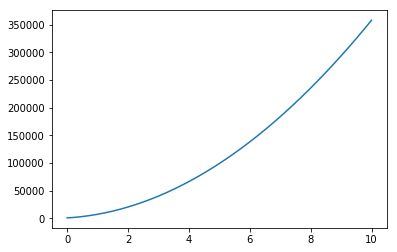

In [119]:
plt.plot(np.linspace(0.0001, 10, 10000), Z.reshape(10000, 10000)[8000,:])

In [141]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import interpolate

# Make data.
X = params[:30,:,0].reshape(-1)
Y =  params[:,:,1][:30].reshape(-1)
Z = params[:30:,:,2].reshape(-1)
Z = interpolate.interp2d(X, Y, Z, kind='cubic')(np.logspace(-4, -2, 10000), np.logspace(-4, -2, 10000))

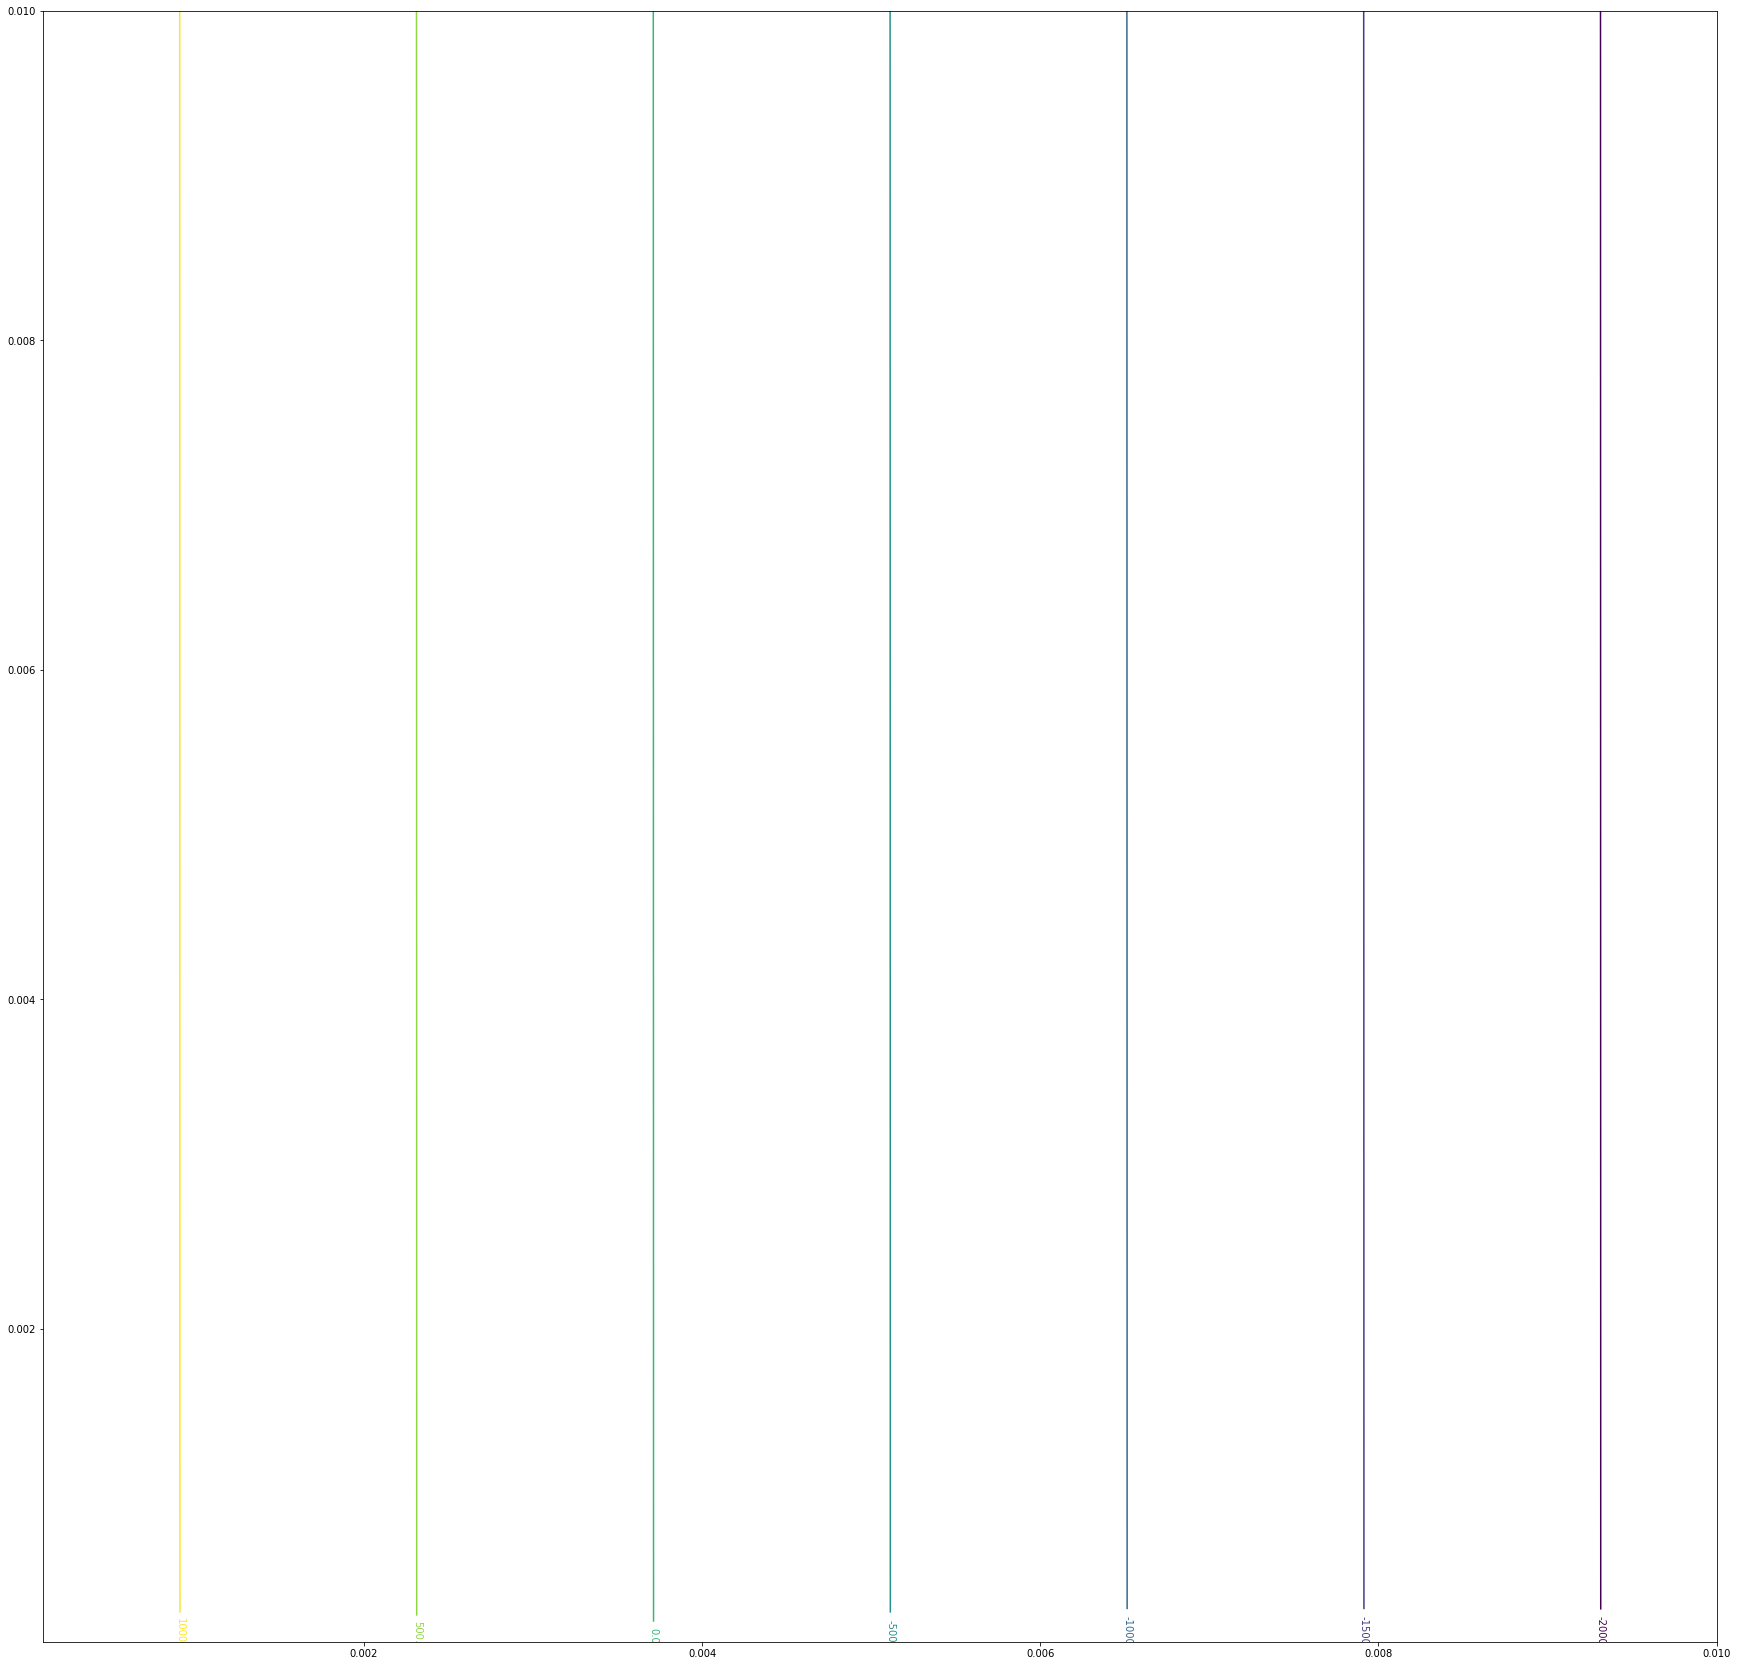

In [142]:
# Plot the surface.
fig = plt.figure(figsize=(30, 30))
contour = plt.contour(np.logspace(-4, -2, 10000), np.logspace(-4, -2, 10000), Z)

#contour = plt.contour(np.linspace(0.0001, 10, 10000), np.linspace(0.0001, 10, 10000), (Z / 100).round(2))

plt.clabel(contour)
plt.show()

## Two Gaussians

### Without Exp Neuron

In [ ]:
net = Classifier(100)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

train(net, optimizer, 200, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

### With Exp Neuron

In [ ]:
net_WITH_EXP

In [ ]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=0.001)

train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=1., epochs=600, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

In [ ]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.SGD(net_WITH_EXP.parameters(), lr=0.001)

train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=0.05, epochs=600, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

In [ ]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=0.0001)

train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=10., epochs=600, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

In [75]:
def plot_dataset(dataset, classes = None):
    if classes is None:
        classes = dataset.classes.numpy()
    colors = np.where(classes <= 0, 'k', 'b')
    plt.figure(figsize=(5,5))
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.scatter(dataset.dots[:, 0].numpy(), dataset.dots[:, 1].numpy(), linewidth=0, c=colors)

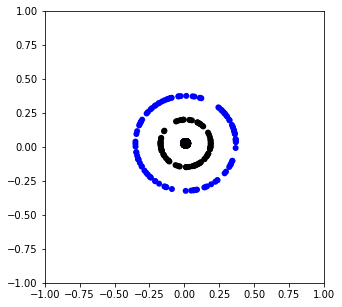

In [76]:
plot_dataset(dataset_c_train)

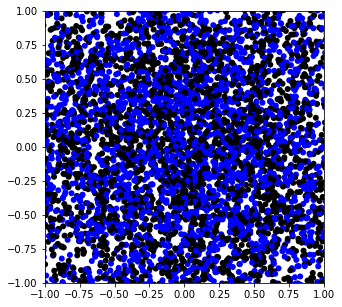

In [77]:
plot_dataset(dataset_g_test)

In [ ]:
plot_dataset(dataset_g_test, get_pure(net(dataset_g_test.dots)))

In [ ]:
plot_dataset(dataset_g_test, get_pure(net_WITH_EXP(dataset_g_test.dots)))

In [ ]:
(np.where(net_WITH_EXP(dataset_g_test.dots).data.numpy() < 0, -1, 1) != dataset_g_test.classes.numpy()).sum()

# MNIST

In [ ]:
import sys
sys.path.insert(0, './MyMNIST/')
from MyMNIST import MNIST_Class_Selection

In [ ]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
dataset_m_train = MNIST_Class_Selection('.', train=True, download=True, transform=transform, class_nums=set([3, 4]))
dataset_m_test = MNIST_Class_Selection('.', train=False, transform=transform, class_nums=set([3, 4]))


dataloader_m_train = DataLoader(dataset_m_train, batch_size=32, shuffle=True)
dataloader_m_test = DataLoader(dataset_m_test, batch_size=32, shuffle=True)

In [ ]:
def train_conv(network, optimizer, epochs, dataloader_train, dataloader_test):
    def loss_func(predict_y, correct_y):
        loss = None
        if use_cuda:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]).cuda(), torch.tensor([0.]).cuda()) ** 3)
        else:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        return loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    try:
        for epoch in range(epochs):
            losses_train_batch = []
            losses_test_batch = []
            misscl_rate_train_batch = []
            misscl_rate_test_batch = []
            
            # train
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)
                
                losses_train_batch.append(get_pure(loss))
                misscl_rate_train_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # test
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)
                
                losses_test_batch.append(get_pure(loss))
                misscl_rate_test_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
            losses_train.append(sum(losses_train_batch)/len(losses_train_batch))
            misscl_rate_train.append(sum(misscl_rate_train_batch))
            losses_test.append(sum(losses_test_batch)/len(losses_test_batch))
            misscl_rate_test.append(sum(misscl_rate_test_batch))

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(losses_train, label='Loss (Train)')
    plt.plot(losses_test, label='Loss (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.subplot(1, 2, 2)
    plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
    plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Number of objects', fontsize=16)
    plt.legend(loc=0, fontsize=16)

In [ ]:
def train_conv_WITH_EXP(network, optimizer, reg_lambda, epochs, dataloader_train, dataloader_test):
    def loss_func(predict_y, correct_y, network, reg_lambda):
        loss = None
        if use_cuda:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]).cuda(), torch.tensor([0.]).cuda()) ** 3)
        else:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        reg_loss = None
        for param in network.explinear.alpha.parameters():
            reg_loss = reg_lambda * param.norm(2)
        return loss + reg_loss, reg_loss
    alpha = []
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    reg_losses = []
    try:
        for epoch in range(epochs):
            losses_train_batch = []
            losses_test_batch = []
            misscl_rate_train_batch = []
            misscl_rate_test_batch = []
            
            # train
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss, _ = loss_func(predict_y, correct_y, network, reg_lambda)
                
                losses_train_batch.append(get_pure(loss))
                misscl_rate_train_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # test
            reg_loss = None
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss, reg_loss = loss_func(predict_y, correct_y, network, reg_lambda)
                
                losses_test_batch.append(get_pure(loss))
                misscl_rate_test_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
             
            alpha.append(network.get_alpha())   
            losses_train.append(sum(losses_train_batch)/len(losses_train_batch))
            misscl_rate_train.append(sum(misscl_rate_train_batch))
            losses_test.append(sum(losses_test_batch)/len(losses_test_batch))
            misscl_rate_test.append(sum(misscl_rate_test_batch))
            reg_losses.append(get_pure(reg_loss))

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(30, 20))
    plt.subplot(2, 3, 1)
    plt.plot(losses_train, label='Loss (Train)')
    plt.plot(losses_test, label='Loss (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.subplot(2, 3, 2)
    plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
    plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Number of objects', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.subplot(2, 3, 3)
    plt.plot(alpha, label='Alpha')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Alpha', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.subplot(2, 3, 4)
    plt.plot(reg_losses, label='Reg Loss')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean reg loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    return alpha

In [ ]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.linear_layers(x).view(-1)

In [ ]:
class ConvClassifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(ConvClassifier_WITH_EXP, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
        self.explinear = ExpLinear(in_size)
    
    def forward(self, x):
        y = self.explinear(x.view(x.shape[0], -1)).view(-1)
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        return self.linear_layers(x).view(-1) + y
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [ ]:
net_m = ConvClassifier()
if use_cuda:
    net_m = net_m.cuda()
optimizer_m = torch.optim.SGD(net_m.parameters(), lr=0.0001)

In [ ]:
train_conv(net_m, optimizer_m, 2, dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)
train_conv(net_m, optimizer_m, 20, dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)

In [ ]:
net_WITH_EXP_m = ConvClassifier_WITH_EXP(28 * 28)
if use_cuda:
    net_WITH_EXP_m = net_WITH_EXP_m.cuda()
optimizer_WITH_EXP_m = torch.optim.SGD(net_WITH_EXP_m.parameters(), lr=0.0001)

In [ ]:
alpha = train_conv_WITH_EXP(net_WITH_EXP_m, optimizer_WITH_EXP_m, reg_lambda=0.5, epochs=20, dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)

In [ ]:
class AugActivation(nn.Module):
    def __init__(self, base_activation):
        super(AugActivation, self).__init__()
        self.base_activation = base_activation
        self.exp_activation = torch.exp
        
    def forward(self, x):
        y_1 = self.base_activation(x[:, :-1])
        y_2 = self.exp_activation(x[:, -1:])
        return torch.cat([y_1, y_2], dim=1)

In [ ]:
gg = AugActivation(nn.PReLU())

In [ ]:
x = Variable(torch.Tensor([[1,2,3,4], [5,6,7,8], [9, 10, 11, 12]]), requires_grad=True)

In [ ]:
x

In [ ]:
y = gg(x).norm(2)

In [ ]:
y.backward()

In [ ]:
print x.grad